Alexander W. Criswell 10/13/25

The mixed-move approach is now working well enough that I'm seeing issues with the sampler trying to match to the spikiness of the data spectrum at higher frequencies, but fundamentally being unable to without improvements that we intend to do down the line (per-frequency parameterization of $\lambda_f$ and $N_f$, per-frequency uncertainty, etc.) This will interfere with our ability to make sure the initial toy model works as it currently exists.

We attempted to alleviate this by focusing on the smoother spectrum at lower frequencies, which helped somewhat but revealed a more fundamental underlying problem. The sampler behaves well and explores the parameter space at first, and is in fact able to find the correct regions of the parameter space and begin to tease out the degeneracies present in the model. However, once it reaches this region, it will inevitably happen to get a Poisson draw at a proposed point which is a too-good match to the observed spectrum. As we currently have no mechanism to continue sampling over the Poisson scatter at a given point in the population parameter space, the likelihood associated with this "near-perfect" Poisson draw is inseparable that point in the parameter space. This results in an extremely low probability of any other proposed point being accepted, as not only would the new point need to be comparable in terms of likelihood at the population level, but would also need to get a similarly "near-perfect" Poisson draw. Hence, the chains get stuck after an initial stage where they act as expected.

TL;DR: Our model breaks down once the sampler constrains the parameter space to a region where Poisson effects dominate, as we are not yet properly accounting for the likelihood scatter arising from Poisson draws at a given point in the population parameter space.

Proposed solution: implement a move which keeps the walker at the same state but forces a new Poisson draw and corresponding likelihood update with 100% acceptance.

The above has been implemented and seems promising. Here we try a longer test run...

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cupy as xp
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator
from matplotlib.pyplot import cycler
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
from matplotlib.collections import LineCollection
import matplotlib.cm
from matplotlib import patches
# import jax.numpy as jnp
# import jax; jax.config.update("jax_enable_x64", True)
from corner import corner, overplot_lines
import legwork as lw
import astropy.units as u
from tqdm import tqdm
from math import factorial
plt.style.use('default')

In [3]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove, DistributionGenerate, MTDistGenMove, Move
from eryn.utils.utility import groups_from_inds
from multiprocessing import Pool

In [4]:
def get_cycle(cmap, N=None, use_index="auto"):
    if isinstance(cmap, str):
        if use_index == "auto":
            if cmap in ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']:
                use_index=True
            else:
                use_index=False
        cmap = plt.get_cmap(cmap)
    if not N:
        N = cmap.N
    if use_index=="auto":
        if cmap.N > 100:
            use_index=False
        elif isinstance(cmap, LinearSegmentedColormap):
            use_index=False
        elif isinstance(cmap, ListedColormap):
            use_index=True
    if use_index:
        ind = np.arange(int(N)) % cmap.N
        return cycler("color",cmap(ind))
    else:
        colors = cmap(np.linspace(0,1,N))
        return cycler("color",colors)

In [5]:
default_cycler=cycler(color=['mediumorchid','teal','navy','firebrick','goldenrod','slategrey'])
plt.rc('axes', prop_cycle=default_cycler)

In [6]:
xp.cuda.is_available()

True

In [7]:
## set environment variables
import os
os.environ['PELARGIR_GPU'] = '1'
os.environ['SCIPY_ARRAY_API'] = '1'
os.environ['PELARGIR_ERYN'] = '1'

In [8]:
if os.environ['PELARGIR_GPU']:
    print('GPU enabled.')

GPU enabled.


In [9]:
import sys
prop_path = '/home/awc/Documents/LISA/projects/lisa_population_inference/pelargir-gb/pelargir/'
sys.path.insert(1, prop_path)
from models import PopModel
from inference import GalacticBinaryPrior, PopulationHyperPrior
from utils import get_amp_freq, lisa_noise_psd
import distributions as st

GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.
GPU requested and available; running Pelargir population inference on GPU.


In [10]:
test_rng = xp.random.default_rng(170817)

In [11]:
test_prior = GalacticBinaryPrior(test_rng)

In [12]:
pop_theta = {'m_mu':xp.array([0.6]),'m_sigma':xp.array([0.15]),
             # 'd_mu':xp.array([30]),'d_sigma':xp.array([10]),
             'd_gamma_a':xp.array([4]),'d_gamma_b':xp.array([4]),
             'a_alpha':xp.array([1/2])}
test_prior.condition(pop_theta)

In [13]:
samps = test_prior.sample_conditional(int(1e7))

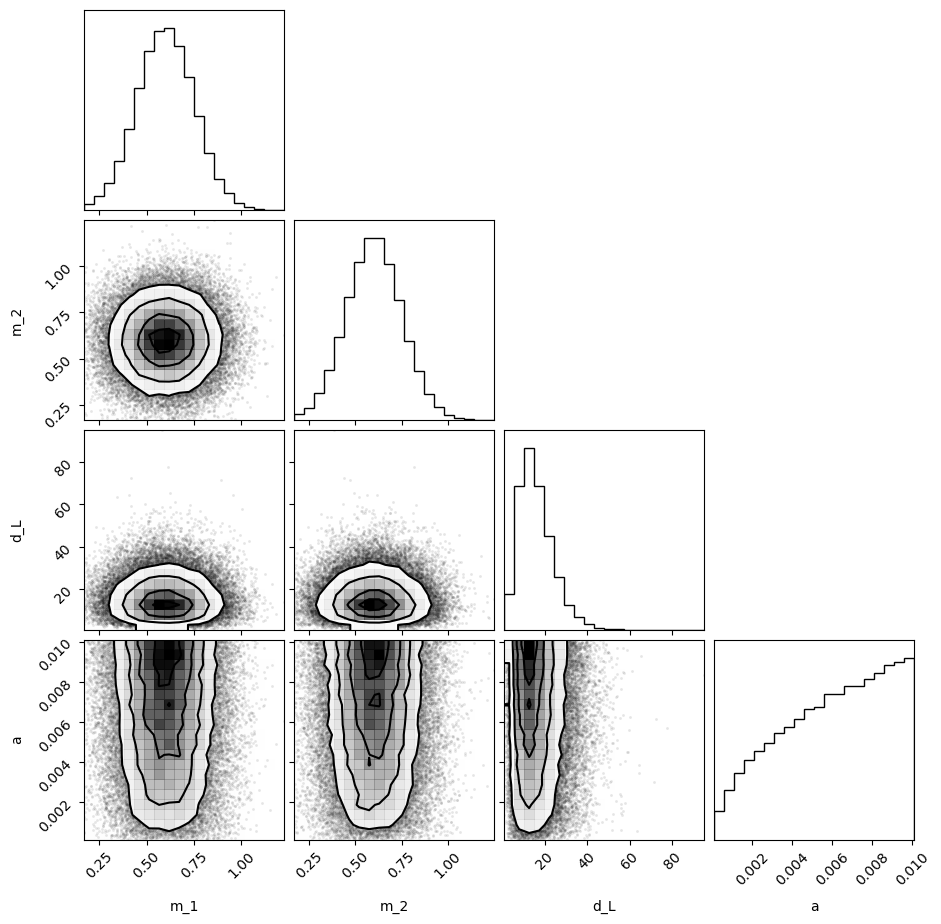

In [14]:
plt.close()
fig = corner(samps[:,::200].get().T,labels=list(test_prior.conditional_dict.keys()))
plt.show()

In [15]:
amps, fgws = get_amp_freq(samps)

In [16]:
test_hprior = PopulationHyperPrior(test_rng)

In [17]:
test_bin_width = 1e-5
test_fbins = xp.arange(3e-4,3e-3,test_bin_width)
test_popmodel = PopModel(1e7,test_rng,hyperprior=test_hprior,Nsamp=1,thresh_compute_frac=1.0,fbins=test_fbins)

In [18]:
test_f, test_fg, N_res = test_popmodel.run_model(pop_theta)

To compare to the initial population draw, we need to run the thresholder on it.

In [19]:
data_N_res, data_coarse_fg = test_popmodel.thresher.serial_array_sort(xp.array([fgws,amps]),
                                                                      test_popmodel.fbins,
                                                                      snr_thresh=test_popmodel.thresh_val,
                                                                      compute_frac=test_popmodel.tc_frac)
data_fg = test_popmodel.reweight_foreground(data_coarse_fg)[1:]

In [20]:
data_N_res

array(246)

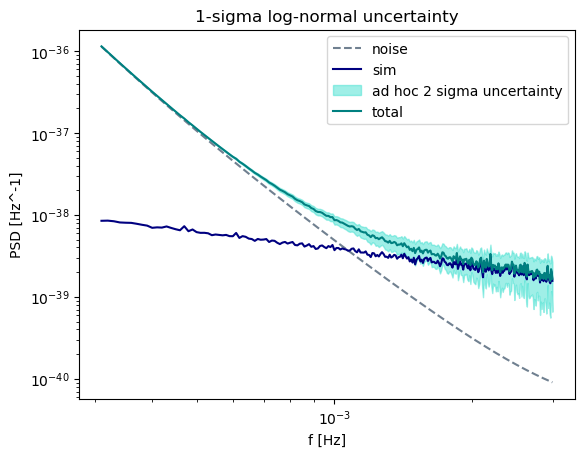

In [21]:
err = 5e-40
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()
plt.figure()
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
# plt.fill_between(total_fs,10**(np.log10(total_spec)-2*err),10**(np.log10(total_spec)+2*err),
#                  color='turquoise',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.fill_between(total_fs,total_spec-2*err,total_spec+2*err,
                 color='turquoise',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
plt.title('1-sigma log-normal uncertainty')
plt.show()

In [22]:
## setup w.r.t. the data
datadict = {'fg':data_fg,
            'fg_sigma':err, ## sigma_fg = 0.1 dex
            'Nres':data_N_res,
            'noise':lisa_noise_psd(test_f)}

In [23]:
test_rng = xp.random.default_rng(42)

In [24]:
translation_dict = {0:'m_mu',
                    1:'m_sigma',
                    2:'d_gamma_a',
                    3:'d_gamma_b',
                    4:'a_alpha'}
## starting with the broader priors
eryn_hyperprior_dict = {0:st.uniform(test_rng,loc=0.5,scale=0.2,cast=True),
                        1:st.invgamma(test_rng,5,cast=True),
                        2:st.uniform(test_rng,loc=2.5,scale=3,cast=True), ## these are pretty arbitrary
                        3:st.uniform(test_rng,loc=2.5,scale=3,cast=True), ## these are pretty arbitrary
                        4:st.uniform(test_rng,0.25,0.75,cast=True)}
eryn_trans_dict = {translation_dict[key]:eryn_hyperprior_dict[key] for key in eryn_hyperprior_dict.keys()}

In [25]:
eryn_trans_dict

{'m_mu': <distributions.uniform at 0x7df4a5488e00>,
 'm_sigma': <distributions.invgamma at 0x7df4a5488ef0>,
 'd_gamma_a': <distributions.uniform at 0x7df4a5488da0>,
 'd_gamma_b': <distributions.uniform at 0x7df4a52088f0>,
 'a_alpha': <distributions.uniform at 0x7df4a5209700>}

In [26]:
eryn_prior = ProbDistContainer(eryn_hyperprior_dict)

In [27]:
eryn_popmodel = PopModel(1e7,test_rng,hyperprior=eryn_trans_dict,fbins=test_fbins)

In [28]:
eryn_popmodel.construct_likelihood(datadict)

In [29]:
log_like_fn = eryn_popmodel.fg_N_ln_prob

In [30]:
ndim = len(eryn_popmodel.hyperprior.hyperprior_dict)
nwalkers = 10

In [31]:
## MH with prior draws as the proposal function
PriorMove = DistributionGenerate({'model_0':eryn_prior})

Build a custom Eryn move for the Poisson sampling...

In [33]:
class PoissonMove(Move):
    '''
    A static Poisson move. This will remain at the current state in the population parameter space, but force reevaluation of the likelihood,
    thereby allowing the sampler to marginalize over the intrinsic Poisson scatter in the likelihood.
    '''

    def __init__(self, **kwargs):

        Move.__init__(self, **kwargs)


    def get_proposal(self, branches_coords, random, branches_inds=None, **kwargs):
        '''
        This is essentially a wrapper; the method will return the current state as the new proposal.

        Args:
            branches_coords (dict): Keys are ``branch_names`` and values are
                np.ndarray[ntemps, nwalkers, nleaves_max, ndim] representing
                coordinates for walkers.
            random (object): Current random state object.
            branches_inds (dict, optional): Keys are ``branch_names`` and values are
                np.ndarray[ntemps, nwalkers, nleaves_max] representing which
                leaves are currently being used. (default: ``None``)
            **kwargs (ignored): This is added for compatibility. It is ignored in this function.

        Returns:
            tuple: (Proposed coordinates, factors) -> (dict, np.ndarray)
        
        '''
        factors = np.zeros((ntemps, nwalkers))
        return branches_coords, factors

    def get_proposal(self, branches_coords, random, branches_inds=None, **kwargs):
        """
        
        This is essentially a wrapper; the method will return the current state as the new proposal.

        Args:
            branches_coords (dict): Keys are ``branch_names`` and values are
                np.ndarray[ntemps, nwalkers, nleaves_max, ndim] representing
                coordinates for walkers.
            random (object): Current random state object.
            branches_inds (dict, optional): Keys are ``branch_names`` and values are
                np.ndarray[ntemps, nwalkers, nleaves_max] representing which
                leaves are currently being used. (default: ``None``)
            **kwargs (ignored): This is added for compatibility. It is ignored in this function.

        Returns:
            tuple: Tuple containing proposal information.
                First entry is the new coordinates as a dictionary with keys
                as ``branch_names`` and values as
                ``double `` np.ndarray[ntemps, nwalkers, nleaves_max, ndim] containing
                proposed coordinates. Second entry
                is the factors associated with the
                proposal necessary for detailed balance. This is effectively
                any term in the detailed balance fraction. +log of factors if
                in the numerator. -log of factors if in the denominator.

        """

        # set up all initial holders
        q = {}
        factors = {}
        new_inds = {}
        if branches_inds is None:
            branches_inds = {
                name: np.ones(coords.shape[:-1], dtype=bool)
                for name, coords in branches_coords
            }

        # iterate through branches and propose new points where inds == True
        for i, (name, coords, inds) in enumerate(
            zip(
                branches_coords.keys(),
                branches_coords.values(),
                branches_inds.values(),
            )
        ):
            # copy over previous info
            ntemps, nwalkers, _, _ = coords.shape
            q[name] = coords.copy()
            new_inds[name] = inds.copy()

            if i == 0:
                factors = np.zeros((ntemps, nwalkers))

            # add coordinates for new leaves
            inds_here = np.where(inds == True)
            num_inds_change = len(inds_here[0])

            old_points = coords[inds_here]

            q[name][inds_here] = old_points

        return q, factors

    def setup(self, branches_coords):
        """Any setup for the proposal.

        Args:
            branches_coords (dict): Keys are ``branch_names``. Values are
                np.ndarray[ntemps, nwalkers, nleaves_max, ndim]. These are the curent
                coordinates for all the walkers.

        """
    
    def propose(self, model, state):
        """Use the move to generate a proposal and compute the acceptance

        Args:
            model (:class:`eryn.model.Model`): Carrier of sampler information.
            state (:class:`State`): Current state of the sampler.

        Returns:
            :class:`State`: State of sampler after proposal is complete.

        """

        self.setup(state.branches_coords)

        # get all branch names for gibbs setup
        all_branch_names = list(state.branches.keys())

        # get initial shape information
        ntemps, nwalkers, _, _ = state.branches[all_branch_names[0]].shape

        # in case there are no leaves yet
        accepted = np.zeros((ntemps, nwalkers), dtype=bool)

        # iterate through gibbs setup
        for branch_names_run, inds_run in self.gibbs_sampling_setup_iterator(
            all_branch_names
        ):
            # setup supplemental information
            if not np.all(
                np.asarray(list(state.branches_supplemental.values())) == None
            ):
                new_branch_supps = deepcopy(state.branches_supplemental)
            else:
                new_branch_supps = None

            if state.supplemental is not None:
                new_supps = deepcopy(state.supplemental)
            else:
                new_supps = None

            # setup information according to gibbs info
            (
                coords_going_for_proposal,
                inds_going_for_proposal,
                at_least_one_proposal,
            ) = self.setup_proposals(
                branch_names_run, inds_run, state.branches_coords, state.branches_inds
            )

            # if no walkers are actually being proposed
            if not at_least_one_proposal:
                continue

            self.current_model = model
            self.current_state = state

            # Get the move-specific proposal.
            q, factors = self.get_proposal(
                coords_going_for_proposal,
                model.random,
                branches_inds=inds_going_for_proposal,
                supps=new_supps,
                branch_supps=new_branch_supps,
            )

            # account for gibbs sampling
            self.cleanup_proposals_gibbs(
                branch_names_run, inds_run, q, state.branches_coords
            )

            # order everything properly
            q, _, new_branch_supps = self.ensure_ordering(
                list(state.branches.keys()), q, state.branches_inds, new_branch_supps
            )

            # if not wrapping with mutliple try (normal route)
            if not hasattr(self, "mt_ll") or not hasattr(self, "mt_lp"):
                # Compute prior of the proposed position
                logp = model.compute_log_prior_fn(q, inds=state.branches_inds)

                self.fix_logp_gibbs(
                    branch_names_run, inds_run, logp, state.branches_inds
                )

                # Compute the lnprobs of the proposed position.
                # Can adjust supplementals in place
                logl, new_blobs = model.compute_log_like_fn(
                    q,
                    inds=state.branches_inds,
                    logp=logp,
                    supps=new_supps,
                    branch_supps=new_branch_supps,
                )

            else:
                # if already computed in multiple try
                logl = self.mt_ll
                logp = self.mt_lp
                new_blobs = None

            # get log posterior
            logP = self.compute_log_posterior(logl, logp)

            # # get previous information
            # prev_logl = state.log_like

            # prev_logp = state.log_prior

            # # takes care of tempering
            # prev_logP = self.compute_log_posterior(prev_logl, prev_logp)

            # # difference
            # lnpdiff = factors + logP - prev_logP

            # 100% acceptance
            accepted = np.ones((ntemps, nwalkers),dtype=bool)

            # Update the parameters
            new_state = State(
                q,
                log_like=logl,
                log_prior=logp,
                blobs=new_blobs,
                inds=state.branches_inds,
                supplemental=new_supps,
                branch_supplemental=new_branch_supps,
            )
            
            state = self.update(state, new_state, accepted)

            # add to move-specific accepted information
            self.accepted += accepted
            self.num_proposals += 1

        # temperature swaps
        if self.temperature_control is not None:
            state = self.temperature_control.temper_comps(state)
        return state, accepted

IndentationError: unindent does not match any outer indentation level (<string>, line 242)

In [33]:
# starting positions
# randomize throughout prior
coords = eryn_prior.rvs(size=(nwalkers,))
# print(coords[i],type(coords[i]))
# check log_like, forcing the initialization to have finite log likelihood
log_like=xp.empty(nwalkers)
for i in tqdm(range(nwalkers)):
    log_like[i] = log_like_fn(coords[i])
    while xp.isinf(log_like[i]):
        coords[i] = eryn_prior.rvs(1)
        log_like[i] = log_like_fn(coords[i])
# log_like = xp.asarray([
#     log_like_fn(coords[i])#, means, invcov)
# for i in range(nwalkers)])
print("Log-likelihood:\n", log_like)

# check log_prior
log_prior = xp.asarray([eryn_prior.logpdf(coords[i]) for i in range(nwalkers)])
print("\nLog-prior:\n", log_prior)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.23it/s]

Log-likelihood:
 [-1.34545126e+02 -3.51342981e+03 -5.20834802e+05 -2.60623773e+04
 -2.75893727e+05 -7.63885202e+02 -1.86836293e+03 -3.06791928e+03
 -5.04170782e+03 -4.10588490e+03]

Log-prior:
 [0.86118009 1.25089694 1.22826266 1.51522869 0.56837611 1.44484385
 1.33217912 1.55505861 1.53629572 1.57200972]


Build an Eryn ensemble with the full move mixture:

In [34]:
ensemble = EnsembleSampler(nwalkers,
                           ndim,
                           log_like_fn,
                           eryn_prior,
                           moves=[(StretchMove(),0.45),(PriorMove,0.1),(PoissonMove(),0.45)],
                           track_moves=True,
                          )
                            # pool=pool)

Let's look at the starting position...

In [35]:
## check intrinsic scatter in the likelihood?
starting_likes = []
starting_astro = []
for i in range(coords.shape[0]):
    like_i, astro_i = eryn_popmodel.fg_N_ln_prob(coords[i,:],return_spec=True)
    starting_likes.append(like_i)
    starting_astro.append(astro_i)

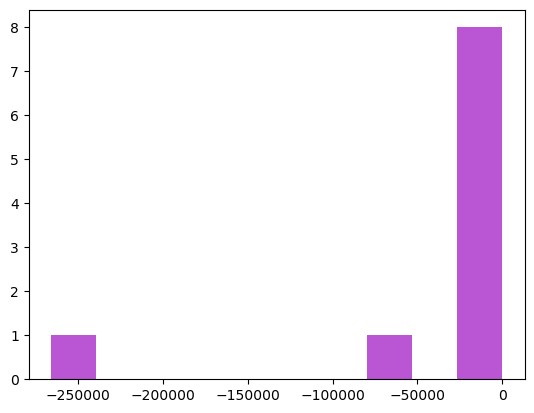

In [36]:
plt.figure()
plt.hist(starting_likes)
plt.show()

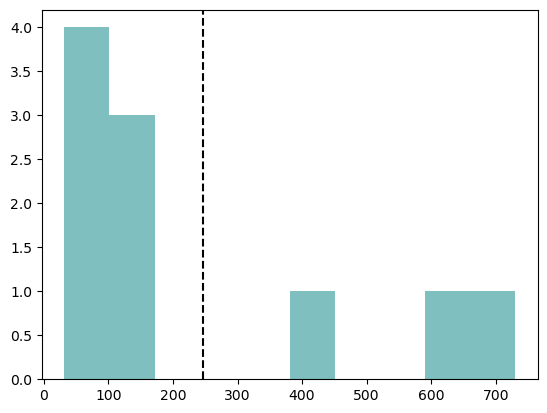

In [37]:
plt.figure()
plt.hist([starting_astro[i][2] for i in range(nwalkers)],color='teal',alpha=0.5)
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

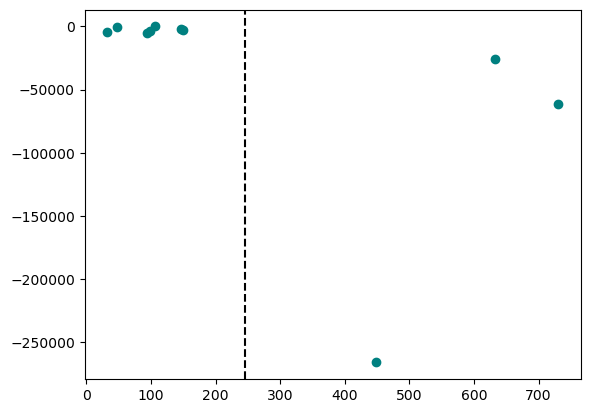

In [38]:
plt.figure()
plt.scatter([starting_astro[i][2] for i in range(nwalkers)],starting_likes,c='teal')
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

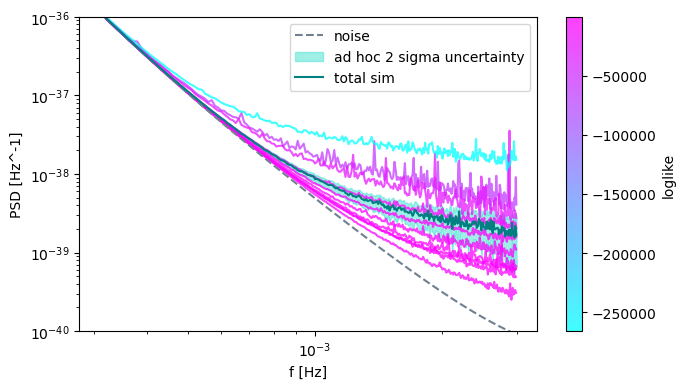

In [39]:
# err = 5e-40
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()
plt.figure(figsize=(7,4))
# label_count = 0
# for i in range(nwalkers):
#     color='dimgrey'
#     if label_count == 0:
#         label='initial draws'
#         label_count +=1
#     else:
#         label='__nolabel__'
        
#     plt.loglog(starting_astro[i][0], lisa_noise_psd(test_f).get()[1:]+starting_astro[i][1],label=label,c=color,alpha=0.75)
spec_draws = [np.column_stack([starting_astro[i][0], lisa_noise_psd(test_f).get()[1:]+starting_astro[i][1]]) for i in range(nwalkers)]
line_collection = LineCollection(spec_draws, array=starting_likes, cmap="cool",alpha=0.75)
plt.gca().add_collection(line_collection)
plt.colorbar(line_collection,label='loglike')
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
# plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
# plt.fill_between(total_fs,10**(np.log10(total_spec)-2*err),10**(np.log10(total_spec)+2*err),
#                  color='teal',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.fill_between(total_fs,total_spec-2*err,total_spec+2*err,
                 color='turquoise',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total sim',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
# plt.title('1-sigma log-normal uncertainty')
plt.ylim(1e-40,1e-36)
# plt.xlim(5e-4,5e-3)
plt.tight_layout()
plt.show()

In [52]:
nsteps = 1000
burn = None
thin_by = 1
out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)
# pool.close()
# pool.join()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [1:09:26<00:00,  4.17s/it]


In [53]:
ensemble.acceptance_fraction

array([[0.58039216, 0.59411765, 0.57647059, 0.46568627, 0.59313725,
        0.59313725, 0.58039216, 0.56862745, 0.45882353, 0.59215686]])

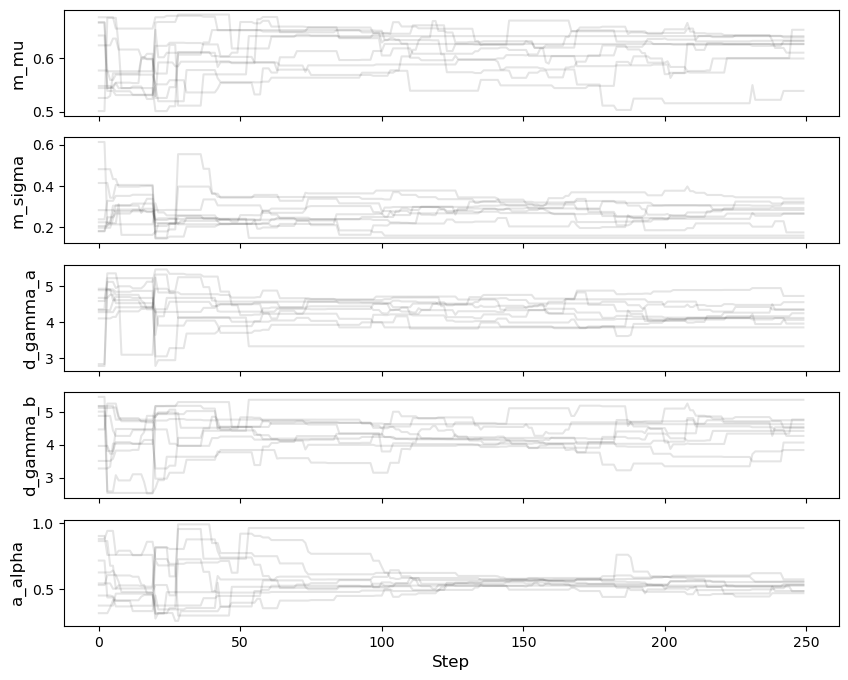

In [89]:
## also look at the walkers
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:250, 0, walk, :, i], color='k', alpha=0.1)
    ax[i].set_ylabel(eryn_popmodel.hpar_names[i],fontsize=12)
ax[i].set_xlabel("Step",fontsize=12)
# plt.savefig('chain_plots_full.png')
plt.show()

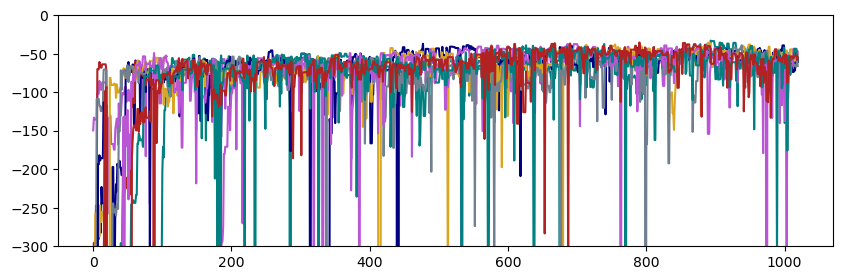

In [67]:
loglike = ensemble.get_log_posterior().reshape(ensemble.get_log_like().shape[0],nwalkers)
plt.figure(figsize=(10,3))
for i in range(nwalkers):
    plt.plot(loglike[:,i])
plt.ylim(-300,0)
plt.show()

Where are they now?

In [56]:
current_state = ensemble.get_chain()['model_0'][-1,...].reshape(10,5)

In [57]:
## check intrinsic scatter in the likelihood?
current_likes = []
current_astro = []
for i in range(coords.shape[0]):
    like_i, astro_i = eryn_popmodel.fg_N_ln_prob(current_state[i,:],return_spec=True)
    current_likes.append(like_i)
    current_astro.append(astro_i)

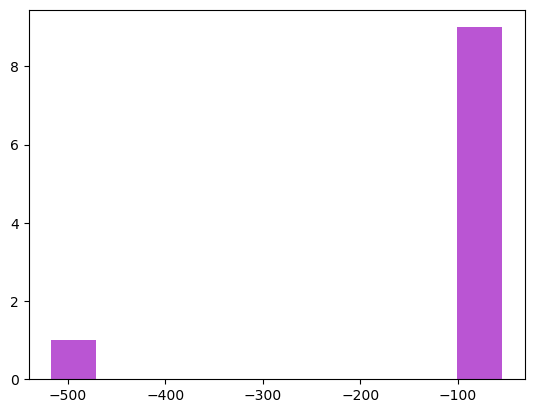

In [58]:
plt.figure()
plt.hist(current_likes)
plt.show()

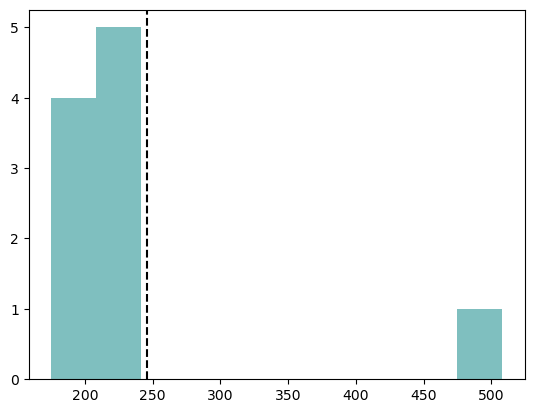

In [59]:
plt.figure()
plt.hist([current_astro[i][2] for i in range(nwalkers)],color='teal',alpha=0.5)
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

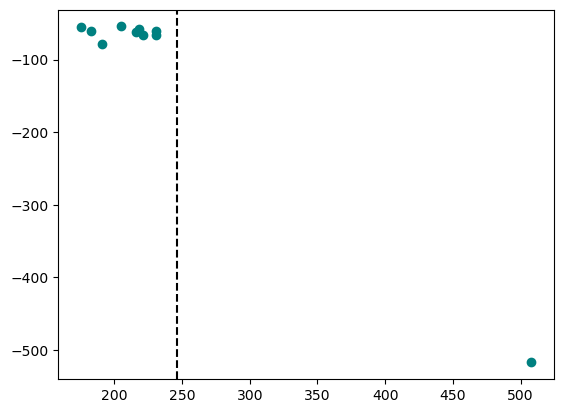

In [60]:
plt.figure()
plt.scatter([current_astro[i][2] for i in range(nwalkers)],current_likes,c='teal')
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

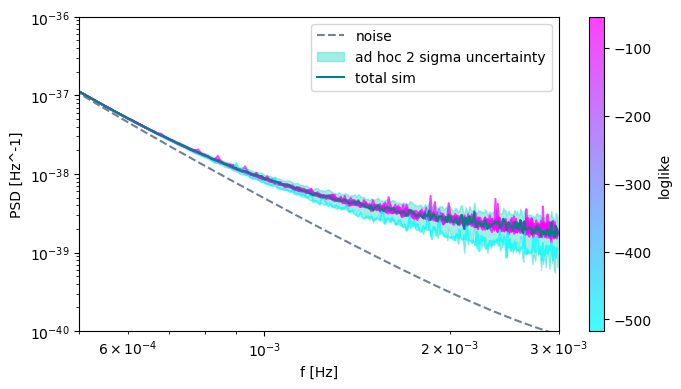

In [61]:
# err = 5e-40
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()
plt.figure(figsize=(7,4))
# label_count = 0
# for i in range(nwalkers):
#     color='dimgrey'
#     if label_count == 0:
#         label='initial draws'
#         label_count +=1
#     else:
#         label='__nolabel__'
        
#     plt.loglog(current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1],label=label,c=color,alpha=0.75)
spec_draws = [np.column_stack([current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1]]) for i in range(nwalkers)]
line_collection = LineCollection(spec_draws, array=current_likes, cmap="cool",alpha=0.75)
plt.gca().add_collection(line_collection)
plt.colorbar(line_collection,label='loglike')
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
# plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
# plt.fill_between(total_fs,10**(np.log10(total_spec)-2*err),10**(np.log10(total_spec)+2*err),
#                  color='teal',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.fill_between(total_fs,total_spec-2*err,total_spec+2*err,
                 color='turquoise',alpha=0.5,label='ad hoc 2 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total sim',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
# plt.title('2-sigma log-normal uncertainty')
plt.ylim(1e-40,1e-36)
plt.xlim(5e-4,3e-3)
plt.tight_layout()
plt.show()

In [62]:
injdict = pop_theta
truths = xp.asnumpy([injdict[key].get() for key in injdict.keys()]).flatten()

In [63]:
truths

array([0.6 , 0.15, 4.  , 4.  , 0.5 ])

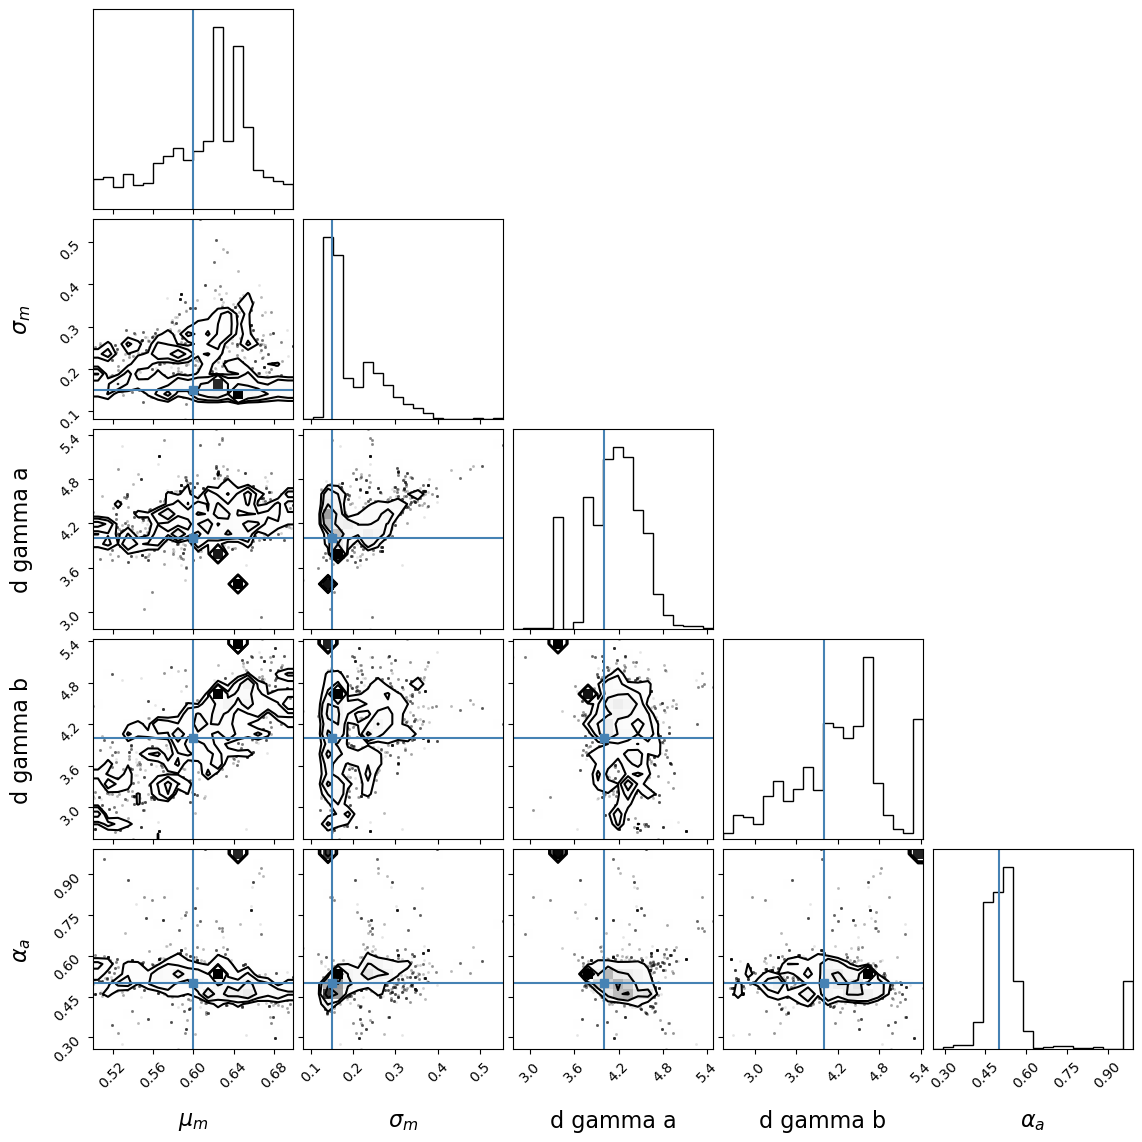

In [70]:
plt.rcParams.update({'axes.labelsize':16})
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)[200:,:]
corner(samples, truths=truths,labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
# plt.savefig('first_initial_result.png',dpi=200)
plt.show()

A couple errant stuck chains, but they're mostly moving around well. Let's get rid of the bad ones:

In [80]:
ensemble.get_chain()['model_0'].shape

(1020, 1, 10, 1, 5)

In [81]:
ensemble.get_chain()['model_0'].squeeze().shape

(1020, 10, 5)

In [82]:
np.var(ensemble.get_chain()['model_0'].squeeze()[200:,:,:],axis=0)

array([[1.19434160e-03, 4.19470218e-03, 2.28338900e-02, 1.05894522e-01,
        1.28752099e-03],
       [1.12494928e-03, 1.34682734e-03, 4.92634809e-02, 2.51677221e-01,
        9.14464351e-04],
       [2.09495440e-03, 6.52904001e-04, 9.97262765e-02, 5.49326724e-01,
        2.00462966e-03],
       [5.04870979e-29, 3.56220003e-30, 1.19985744e-27, 7.09974815e-28,
        1.18452395e-29],
       [3.86205448e-03, 4.30379432e-03, 7.24012733e-02, 3.74958476e-01,
        2.32439713e-03],
       [3.19843890e-03, 5.62826822e-03, 6.55146198e-02, 3.04577042e-01,
        2.05936852e-03],
       [1.20091726e-03, 1.93352915e-03, 7.74759482e-02, 6.92442585e-02,
        8.33450479e-04],
       [2.50654960e-03, 2.91668952e-03, 1.16374103e-02, 1.93470094e-01,
        1.33555305e-03],
       [1.97215226e-31, 6.52042842e-30, 9.38941692e-28, 3.97664782e-27,
        9.98402083e-29],
       [1.57000927e-03, 3.11913142e-03, 2.15789571e-02, 3.77402546e-01,
        5.82379453e-04]])

In [83]:
good_filt = np.median(np.var(ensemble.get_chain()['model_0'].squeeze()[200:,:,:],axis=0),axis=1) > 1e-16

In [84]:
good_filt

array([ True,  True,  True, False,  True,  True,  True,  True, False,
        True])

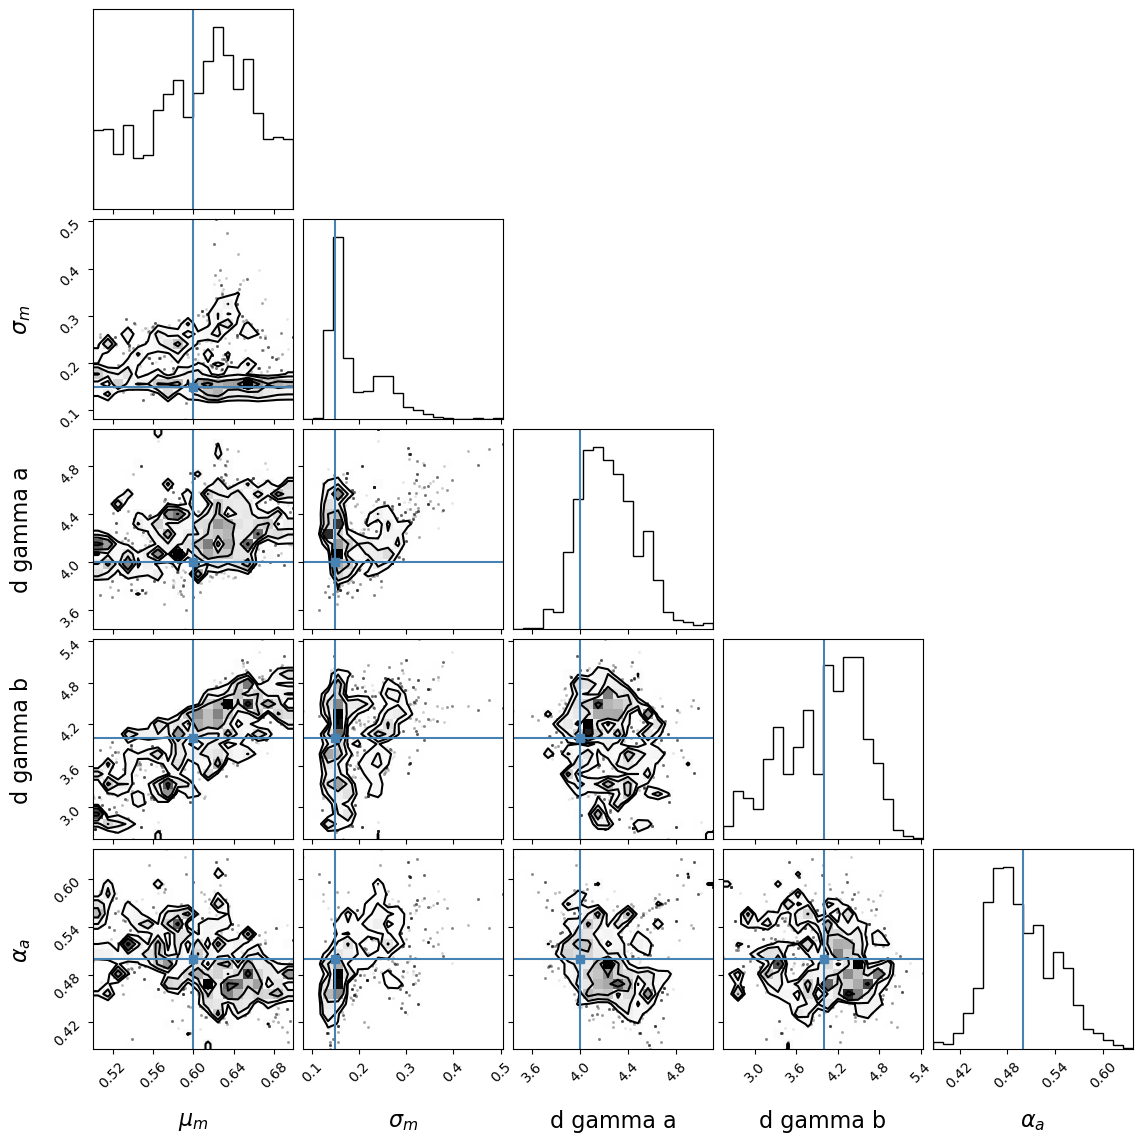

In [87]:
burned_filtered_samples = ensemble.get_chain()['model_0'].squeeze()[200:,good_filt,:]

plt.rcParams.update({'axes.labelsize':16})
corner(burned_filtered_samples.reshape(-1,ndim), 
       truths=truths,
       labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
# plt.savefig('first_initial_result.png',dpi=200)
plt.show()

In [93]:
out.branches['model_0'].coords

array([[[[0.59838548, 0.1622448 , 4.12822947, 3.88914037, 0.4775306 ]],

        [[0.63395496, 0.14511561, 3.88123428, 4.61795466, 0.51807844]],

        [[0.63468954, 0.15117935, 3.96787047, 4.53958596, 0.48281973]],

        [[0.62628988, 0.15991165, 3.85359152, 4.62214638, 0.52622237]],

        [[0.64971184, 0.15281824, 4.11783878, 4.51323215, 0.46181084]],

        [[0.68440965, 0.15565599, 4.48812288, 4.47114459, 0.43786995]],

        [[0.61412995, 0.1508604 , 3.95399311, 4.30296283, 0.4663773 ]],

        [[0.62268943, 0.15489907, 3.96669267, 4.40600721, 0.48442118]],

        [[0.6409782 , 0.14885941, 3.32391647, 5.3636482 , 0.96543706]],

        [[0.6495614 , 0.14948047, 4.11932992, 4.52873083, 0.47602582]]]])

In [102]:
out.branches['model_0'].coords[np.isnan(out.log_prior),:]

array([[[0.62628988, 0.15991165, 3.85359152, 4.62214638, 0.52622237]],

       [[0.6409782 , 0.14885941, 3.32391647, 5.3636482 , 0.96543706]]])

In [110]:
eryn_prior.logpdf(out.branches['model_0'].coords[np.isnan(out.log_prior),:][1,:])

array([1.53271603])

In [114]:
ensemble.compute_log_prior(out.branches_coords)

array([[1.57031428, 1.51223601, 1.54301654, 1.56729591, 1.54926092,
        1.55816408, 1.54170365, 1.55601869, 1.53271603, 1.53564622]])

In [115]:
out.log_prior

array([[1.57031428, 1.51223601, 1.54301654,        nan, 1.54926092,
        1.55816408, 1.54170365, 1.55601869,        nan, 1.53564622]])

In [118]:
out.log_prior >= ensemble.compute_log_prior(out.branches_coords)

array([[ True,  True,  True, False,  True,  True,  True,  True, False,
         True]])

Okay, I need to go to bed. But there is something exquisitely *rotten* in Denmark. DEEPLY unclear how on earth this is happening, but I suspect it is central to the chain issues we have been seeing...

In [101]:
## force a prior draw update on the out-of-bounds walkers
N_nan = out.branches['model_0'].coords[np.isnan(out.log_prior),:].shape[0]
eryn_prior.rvs(N_nan)

array([[0.54981305, 0.07161996, 2.98360559, 4.68161748, 0.38560182],
       [0.52070231, 0.46755988, 3.55498729, 4.48546451, 0.83965466]])

In [106]:
nsteps = 100
burn = None
thin_by = 1
out = ensemble.run_mcmc(None, nsteps, burn=burn, progress=True, thin_by=thin_by)
# pool.close()
# pool.join()

ValueError: The initial log_prior was NaN

In [97]:
ensemble.acceptance_fraction

array([[0.06451613, 0.09677419, 0.06129032, 0.09354839, 0.06451613,
        0.04516129, 0.03225806, 0.03548387, 0.08387097, 0.04193548]])

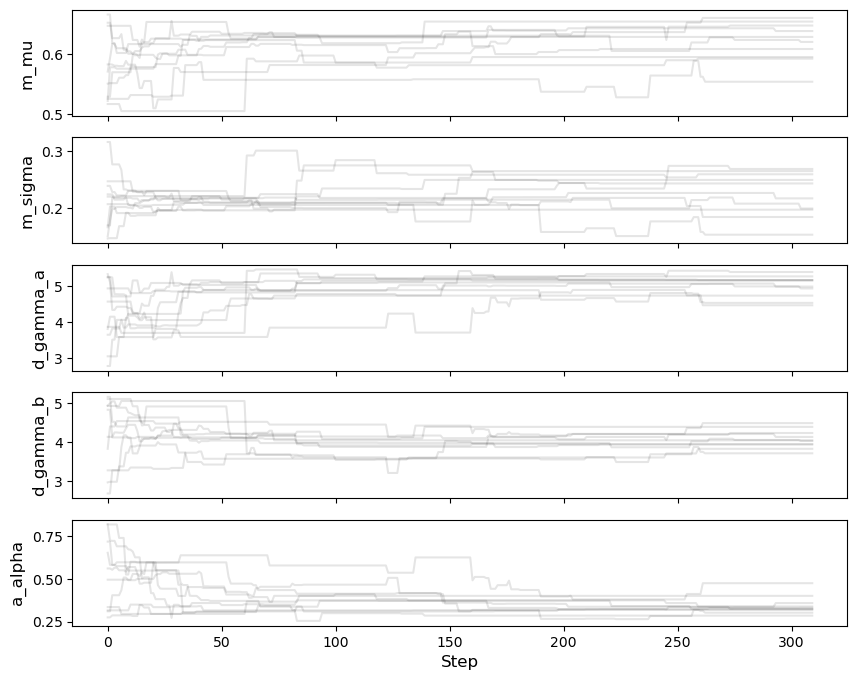

In [98]:
## also look at the walkers
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i], color='k', alpha=0.1)
    ax[i].set_ylabel(eryn_popmodel.hpar_names[i],fontsize=12)
ax[i].set_xlabel("Step",fontsize=12)
# plt.savefig('chain_plots_full.png')
plt.show()

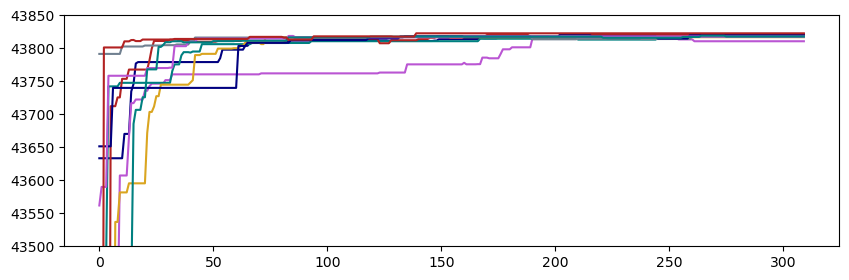

In [118]:
default_cycler=cycler(color=['navy','mediumorchid','teal','firebrick','goldenrod','slategrey'])
plt.rc('axes', prop_cycle=default_cycler)
loglike = ensemble.get_log_like().reshape(ensemble.get_log_like().shape[0],nwalkers)
plt.figure(figsize=(10,3))
for i in range(nwalkers):
    plt.plot(loglike[:,i])
plt.ylim(43500,43850)
plt.show()

In [100]:
current_state = ensemble.get_chain()['model_0'][-1,...].reshape(10,5)

In [101]:
## check intrinsic scatter in the likelihood?
current_likes = []
current_astro = []
for i in range(coords.shape[0]):
    like_i, astro_i = eryn_popmodel.fg_N_ln_prob(current_state[i,:],return_spec=True)
    current_likes.append(like_i)
    current_astro.append(astro_i)

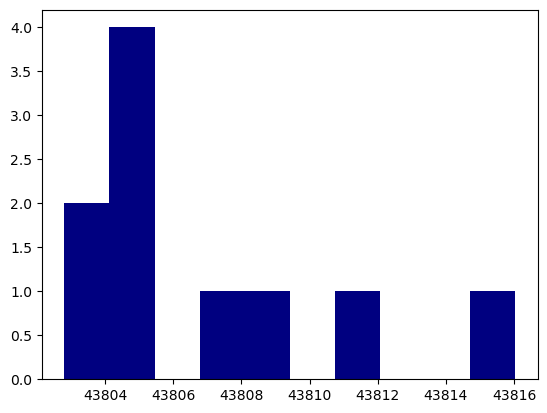

In [102]:
plt.figure()
plt.hist(current_likes)
plt.show()

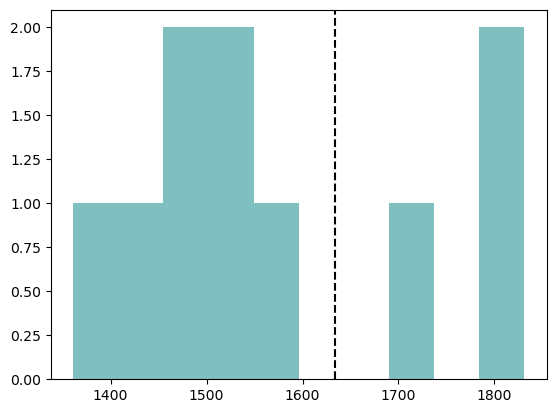

In [103]:
plt.figure()
plt.hist([current_astro[i][2] for i in range(nwalkers)],color='teal',alpha=0.5)
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

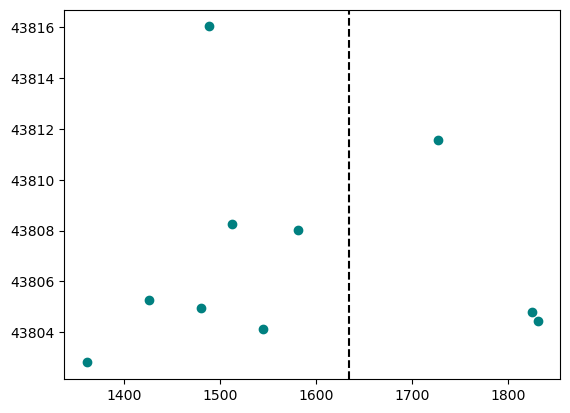

In [104]:
plt.figure()
plt.scatter([current_astro[i][2] for i in range(nwalkers)],current_likes,c='teal')
plt.axvline(datadict['Nres'].get(),c='k',ls='--')
plt.show()

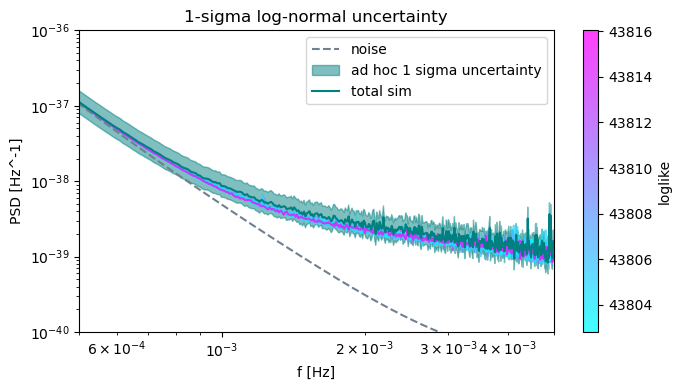

In [105]:
# err = 5e-40
total_fs = test_f.get()
total_spec = data_fg.get() + lisa_noise_psd(test_f).get()

plt.rcParams["axes.prop_cycle"] = get_cycle("cool", nwalkers)
plt.figure(figsize=(7,4))
# label_count = 0
# for i in range(nwalkers):
#     color='dimgrey'
#     if label_count == 0:
#         label='initial draws'
#         label_count +=1
#     else:
#         label='__nolabel__'
        
#     plt.loglog(current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1],label=label,c=color,alpha=0.75)
spec_draws = [np.column_stack([current_astro[i][0], lisa_noise_psd(test_f).get()[1:]+current_astro[i][1]]) for i in range(nwalkers)]
line_collection = LineCollection(spec_draws, array=current_likes, cmap="cool",alpha=0.75)
plt.gca().add_collection(line_collection)
plt.colorbar(line_collection,label='loglike')
plt.loglog(total_fs,lisa_noise_psd(test_f).get(),c='slategrey',ls='--',label='noise')
# plt.loglog(total_fs,data_fg.get(),c='navy',label='sim')
plt.fill_between(total_fs,10**(np.log10(total_spec)-err),10**(np.log10(total_spec)+err),
                 color='teal',alpha=0.5,label='ad hoc 1 sigma uncertainty')
# plt.fill_between(total_fs,total_spec-err,total_spec+err,
#                  color='turquoise',alpha=0.5,label='ad hoc 1 sigma uncertainty')
plt.loglog(total_fs,total_spec,label='total sim',c='teal')
plt.legend()
plt.xlabel('f [Hz]')
plt.ylabel('PSD [Hz^-1]')
plt.title('1-sigma log-normal uncertainty')
plt.ylim(1e-40,1e-36)
plt.xlim(5e-4,5e-3)
plt.tight_layout()
plt.show()

In [107]:
injdict = pop_theta
truths = xp.asnumpy([injdict[key].get() for key in injdict.keys()]).flatten()

In [108]:
truths

array([0.6 , 0.15, 4.  , 4.  , 0.5 ])

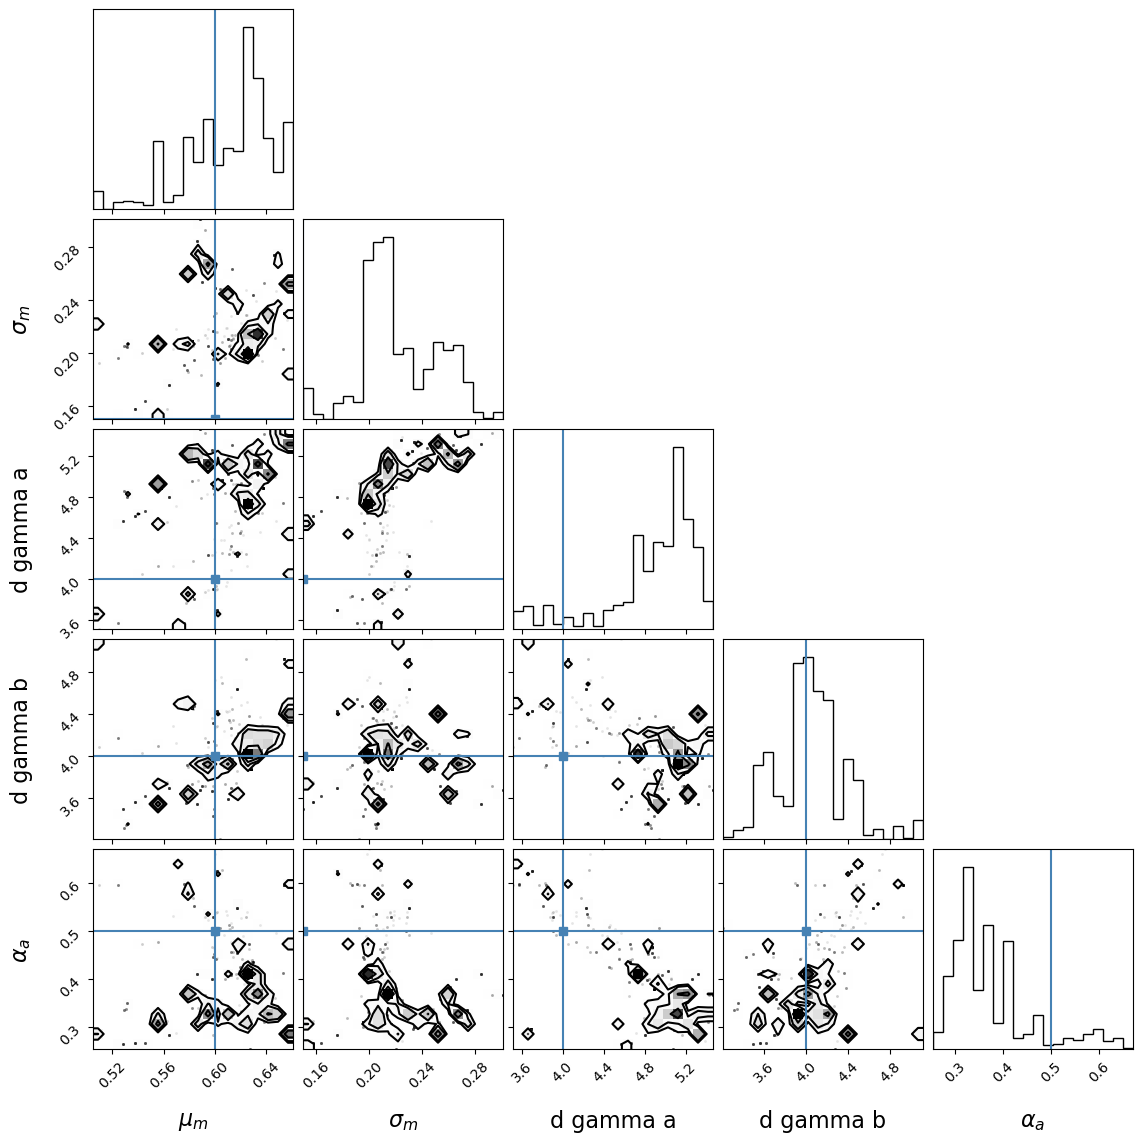

In [113]:
plt.rcParams.update({'axes.labelsize':16})
samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)[100:,:]
corner(samples, truths=truths,labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
# plt.savefig('first_initial_result.png',dpi=200)
plt.show()

Okay, cool. The mixed moves seems to be successful in allowing the walkers to move around the space. The stretch move is good at efficiently moving around the likelihood but can easily leave walkers stuck out of bounds; occasionally providing a prior draw proposal (which is very inefficient on its own) makes sure that any walkers stuck at -inf prior probability are brought back into the fold.

This is now working well enough that I'm seeing issues with the sampler trying to match to the spikiness of the data spectrum at higher frequencies, but fundamentally being unable to without improvements that we intend to do down the line (per-frequency parameterization of $\lambda_f$ and $N_f$, per-frequency uncertainty, etc.) This will interfere with our ability to make sure the initial toy model works as it currently exists. A few options to deal with this:

- Apply some sort of smoothing filter to the data spectrum to reduce spikiness. This may have the inadvertant effect of biasing the analysis towards populations with smoother spectra (i.e. fewer subthreshold sources), but this should at least partially be balanced out by the $N_{res}$ Poisson term.
- Dive right in and implement the above changes right now
- Further reduce the frequency range we consider, cutting out the problem area entirely.

I'm inclined to take the latter route for the moment; it should allow us to test the fidelity of the current model while avoiding further complications, and will have the nice side effect of greatly improving the speed of each test run.

In [53]:
nsteps = 5000
burn = None
thin_by = 1
out = ensemble.run_mcmc(out, nsteps, burn=burn, progress=True, thin_by=thin_by)
# pool.close()
# pool.join()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [9:47:09<00:00,  7.05s/it]


In [54]:
ensemble.acceptance_fraction

array([[0.00054054, 0.00126126, 0.0027027 , 0.00234234, 0.0009009 ,
        0.00144144, 0.0009009 , 0.0009009 , 0.0009009 , 0.00216216]])

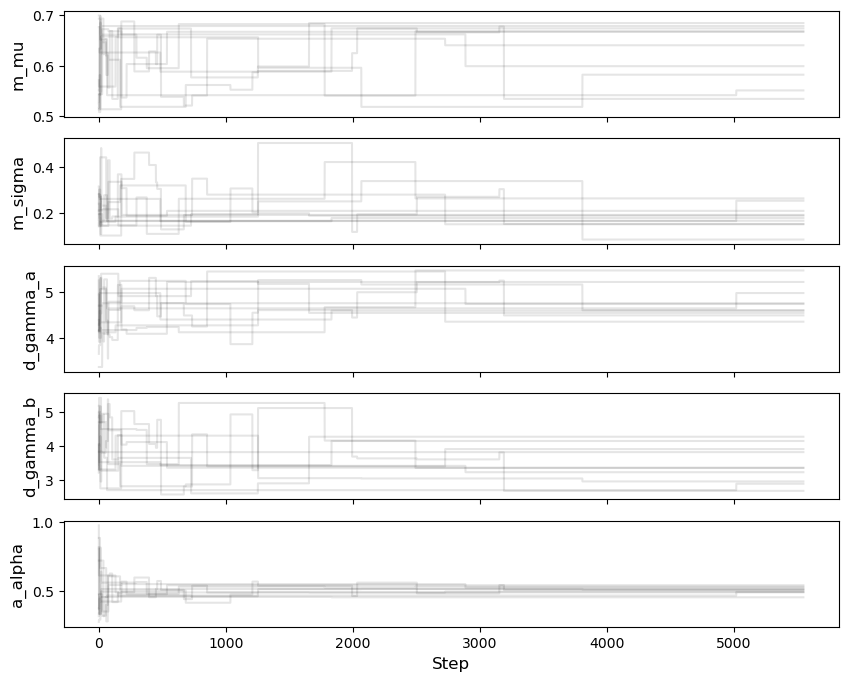

In [55]:
## also look at the walkers
fig, ax = plt.subplots(ndim, 1, sharex=True)
fig.set_size_inches(10, 8)
for i in range(ndim):
    for walk in range(nwalkers):
        ax[i].plot(ensemble.get_chain()['model_0'][:, 0, walk, :, i], color='k', alpha=0.1)
    ax[i].set_ylabel(eryn_popmodel.hpar_names[i],fontsize=12)
ax[i].set_xlabel("Step",fontsize=12)
# plt.savefig('chain_plots_full.png')
plt.show()

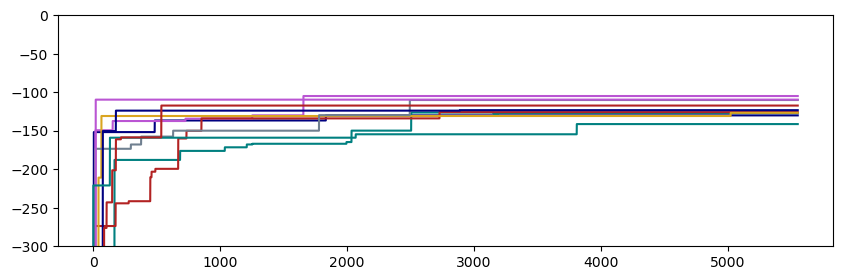

In [67]:
loglike = ensemble.get_log_like().reshape(ensemble.get_log_like().shape[0],10)
plt.figure(figsize=(10,3))
for i in range(10):
    plt.plot(loglike[:,i])
plt.ylim(-300,0)
plt.show()

In [59]:
np.var(ensemble.get_chain()['model_0'].reshape(ensemble.get_chain()['model_0'].shape[0],10,5),axis=0)

array([[1.35193698e-03, 6.49956772e-04, 2.14992682e-02, 1.06054255e-01,
        6.94298532e-06],
       [1.33606323e-03, 2.50643837e-04, 7.80392793e-02, 3.51750208e-01,
        2.13530591e-04],
       [3.02891176e-03, 1.47768031e-02, 1.12491821e-01, 7.69997004e-01,
        1.81352853e-03],
       [1.31503923e-03, 6.65441324e-03, 2.57477949e-01, 1.98284178e-01,
        5.39620113e-04],
       [2.12091607e-04, 7.37357183e-04, 1.15127148e-02, 1.91873459e-02,
        4.97997130e-04],
       [2.12738873e-03, 5.03119297e-03, 3.60813658e-01, 5.93750334e-01,
        2.65418282e-04],
       [1.03128451e-03, 4.05948343e-04, 4.37977368e-02, 6.35457758e-02,
        4.71295718e-04],
       [7.59299109e-05, 1.17403183e-05, 2.01610085e-03, 1.39292843e-03,
        1.20600915e-04],
       [2.40437803e-03, 1.07420274e-02, 1.50463911e-01, 2.71259653e-01,
        3.59145507e-04],
       [5.29685693e-04, 4.02329071e-04, 9.79676458e-02, 6.19889806e-02,
        9.23384919e-04]])

In [60]:
injdict = pop_theta
truths = xp.asnumpy([injdict[key].get() for key in injdict.keys()]).flatten()

In [61]:
truths

array([0.6 , 0.15, 4.  , 4.  , 0.5 ])

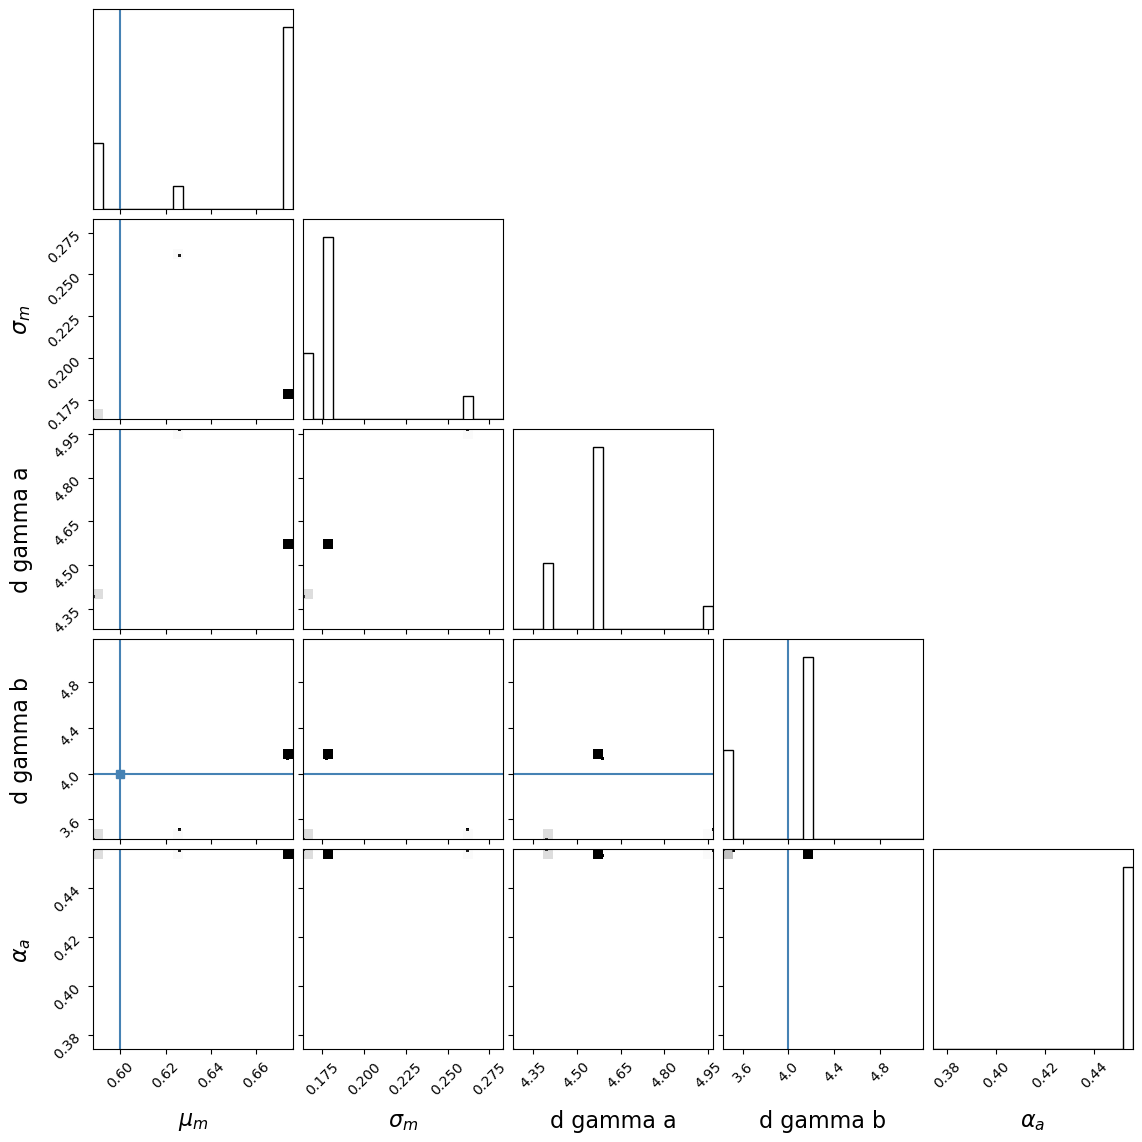

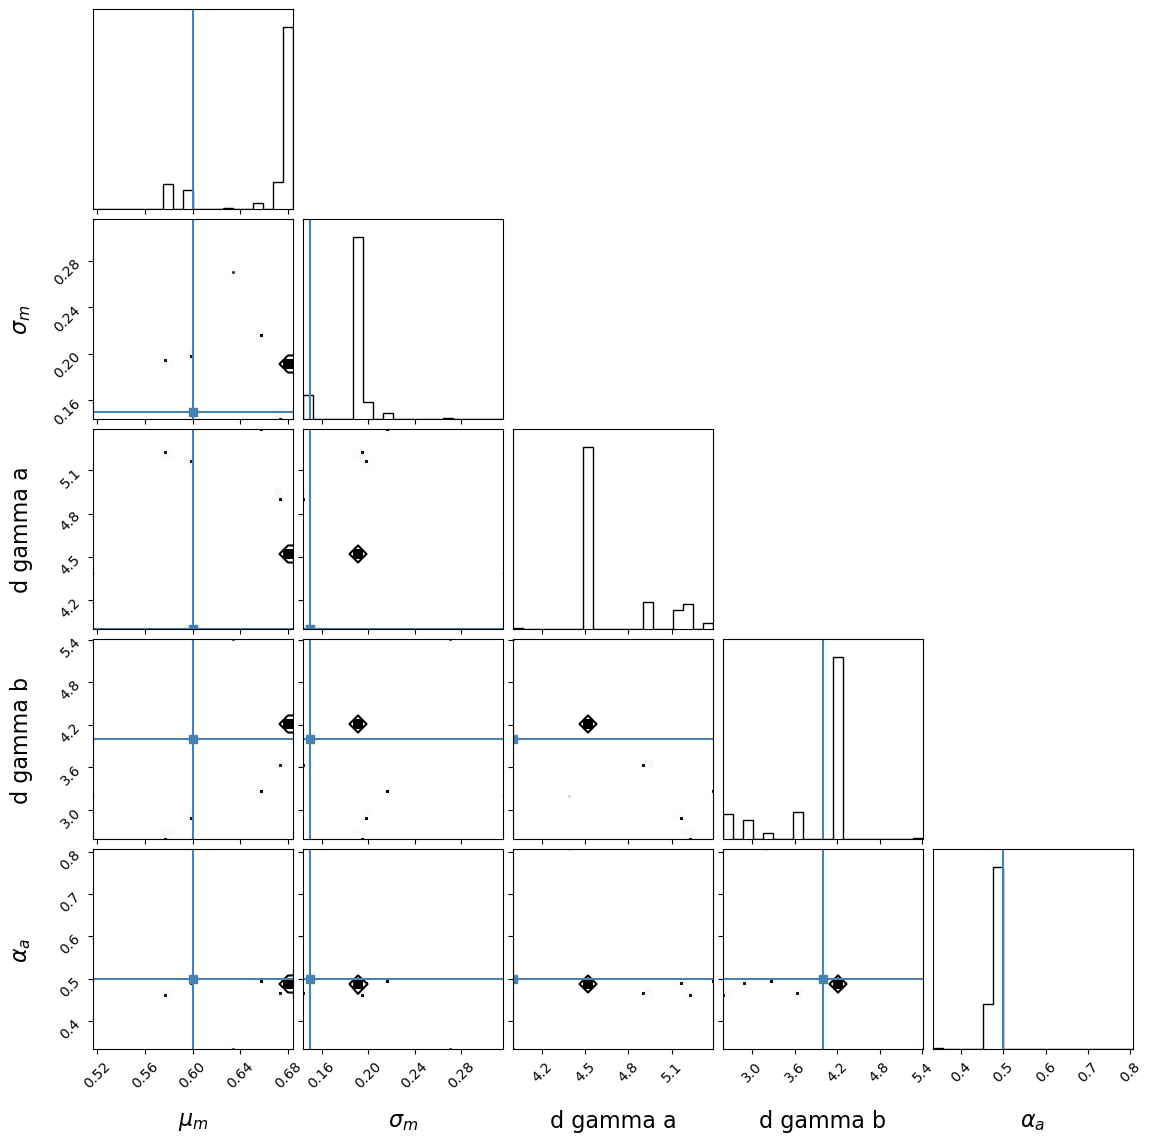

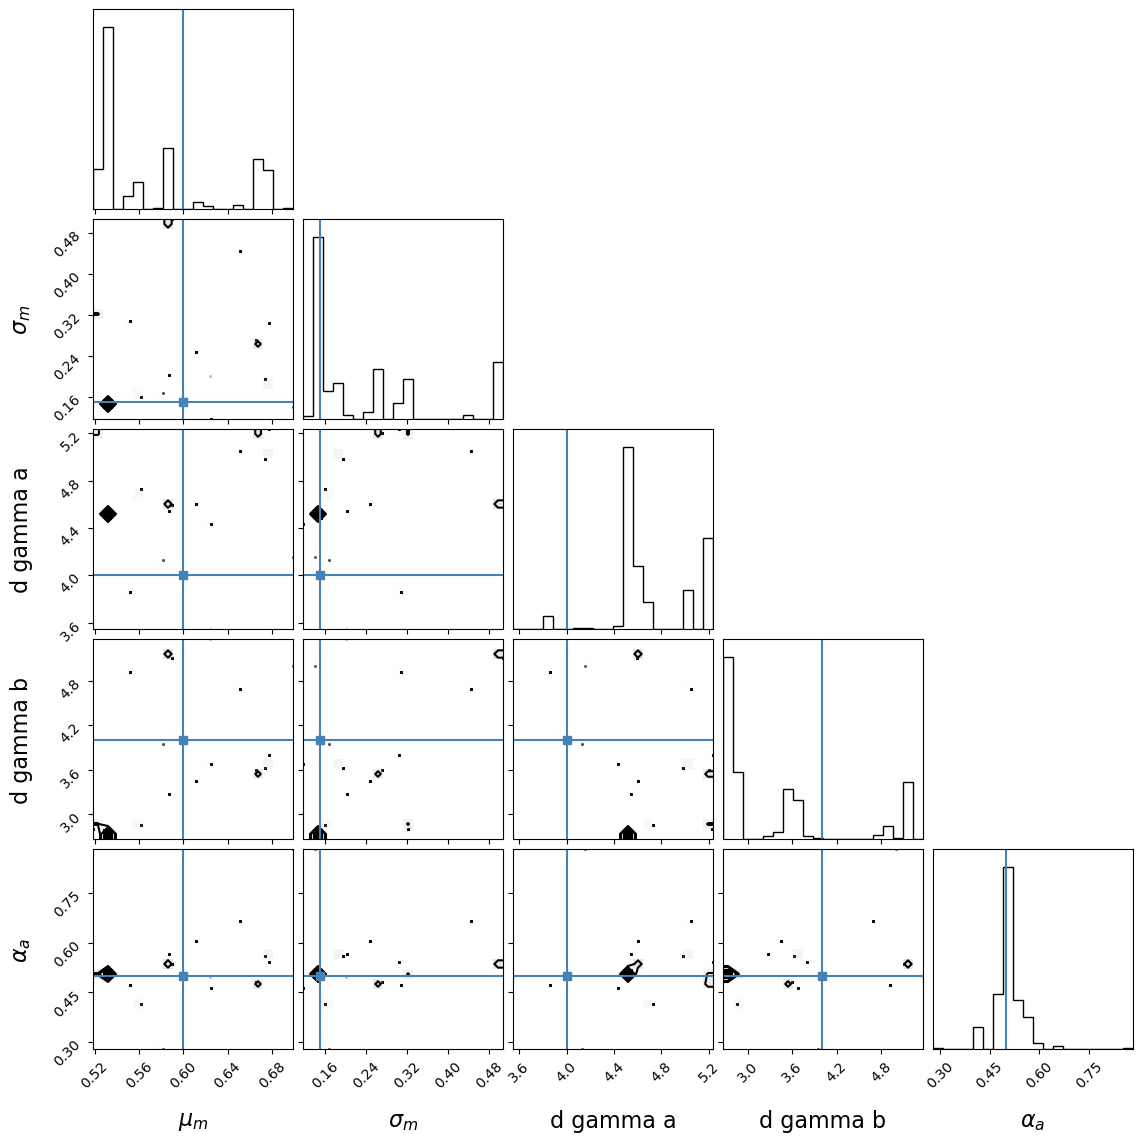

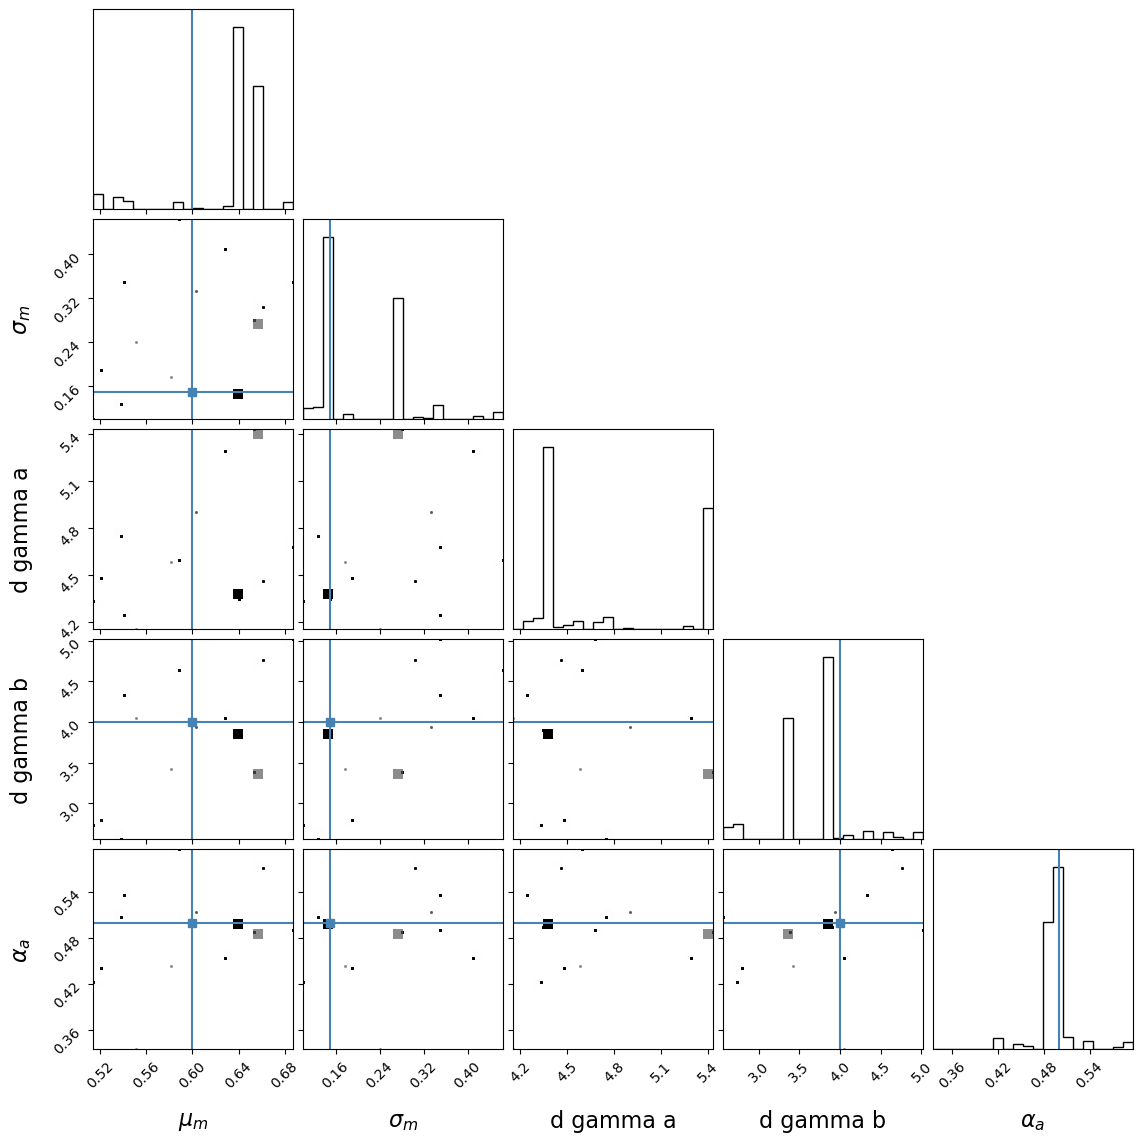

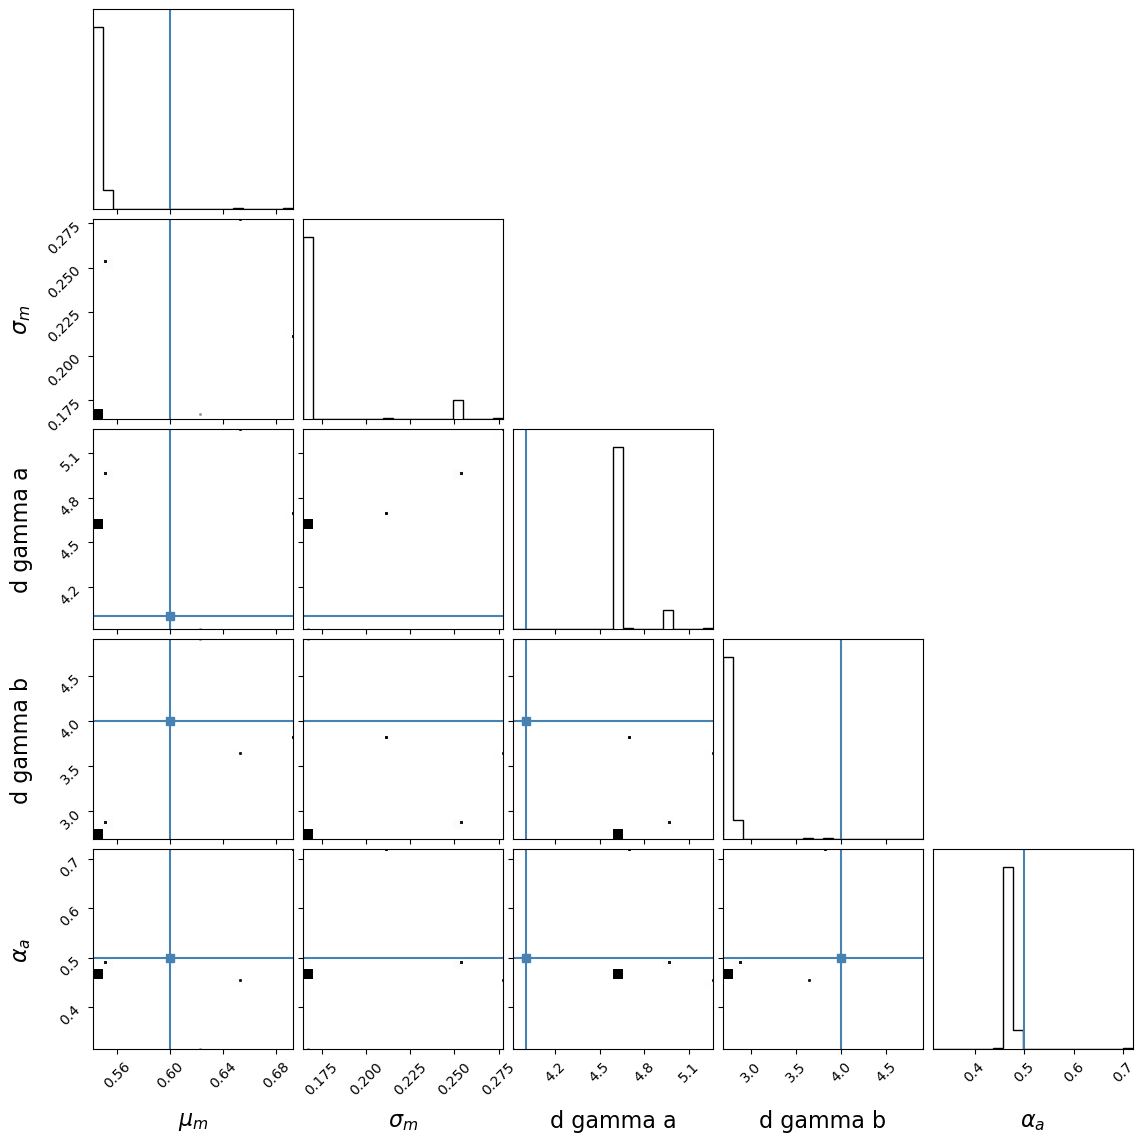

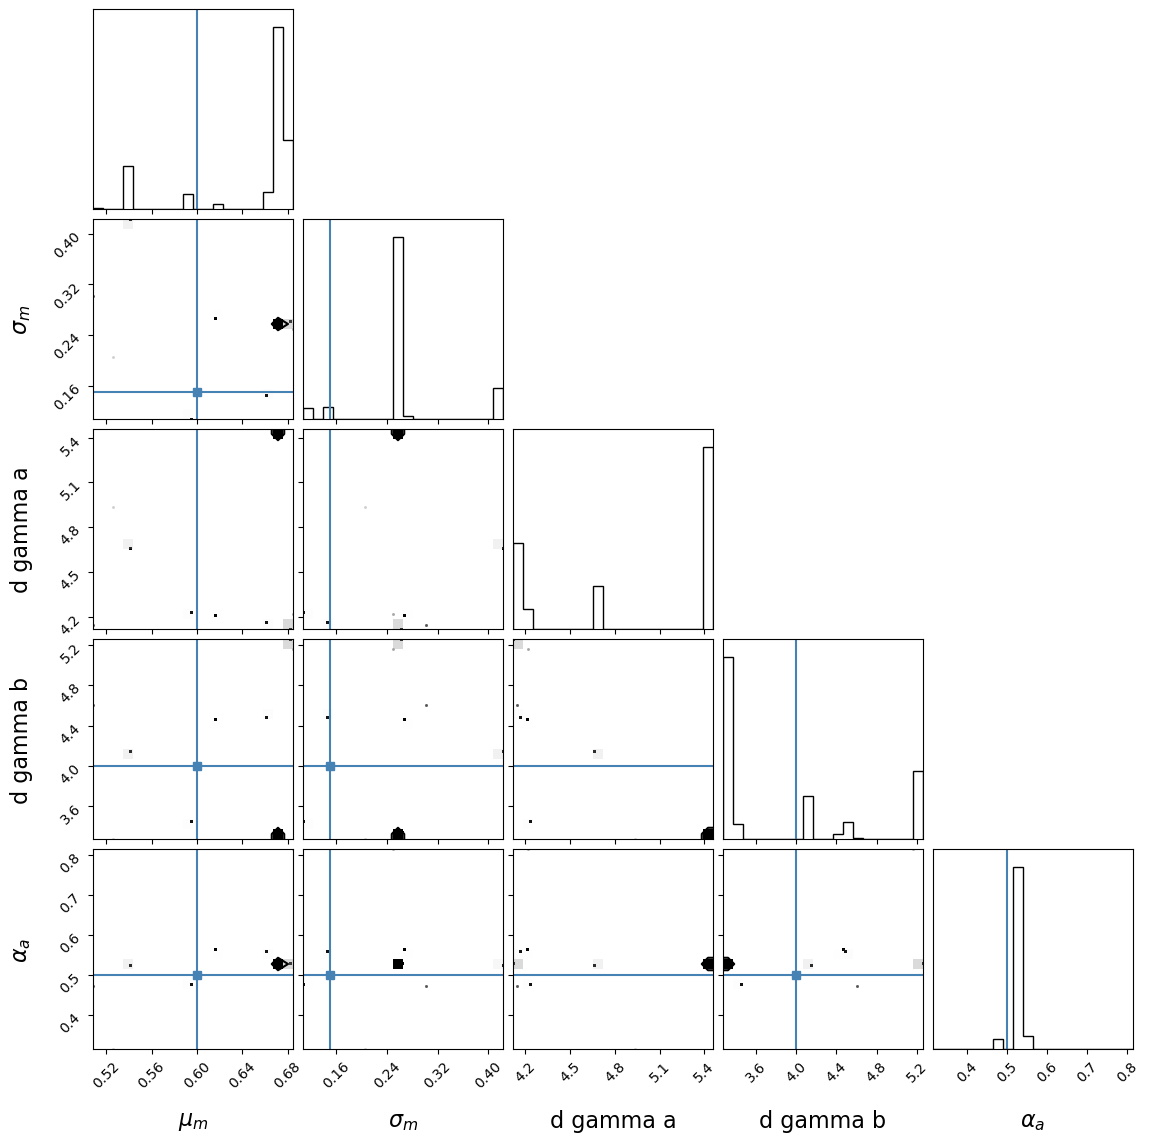

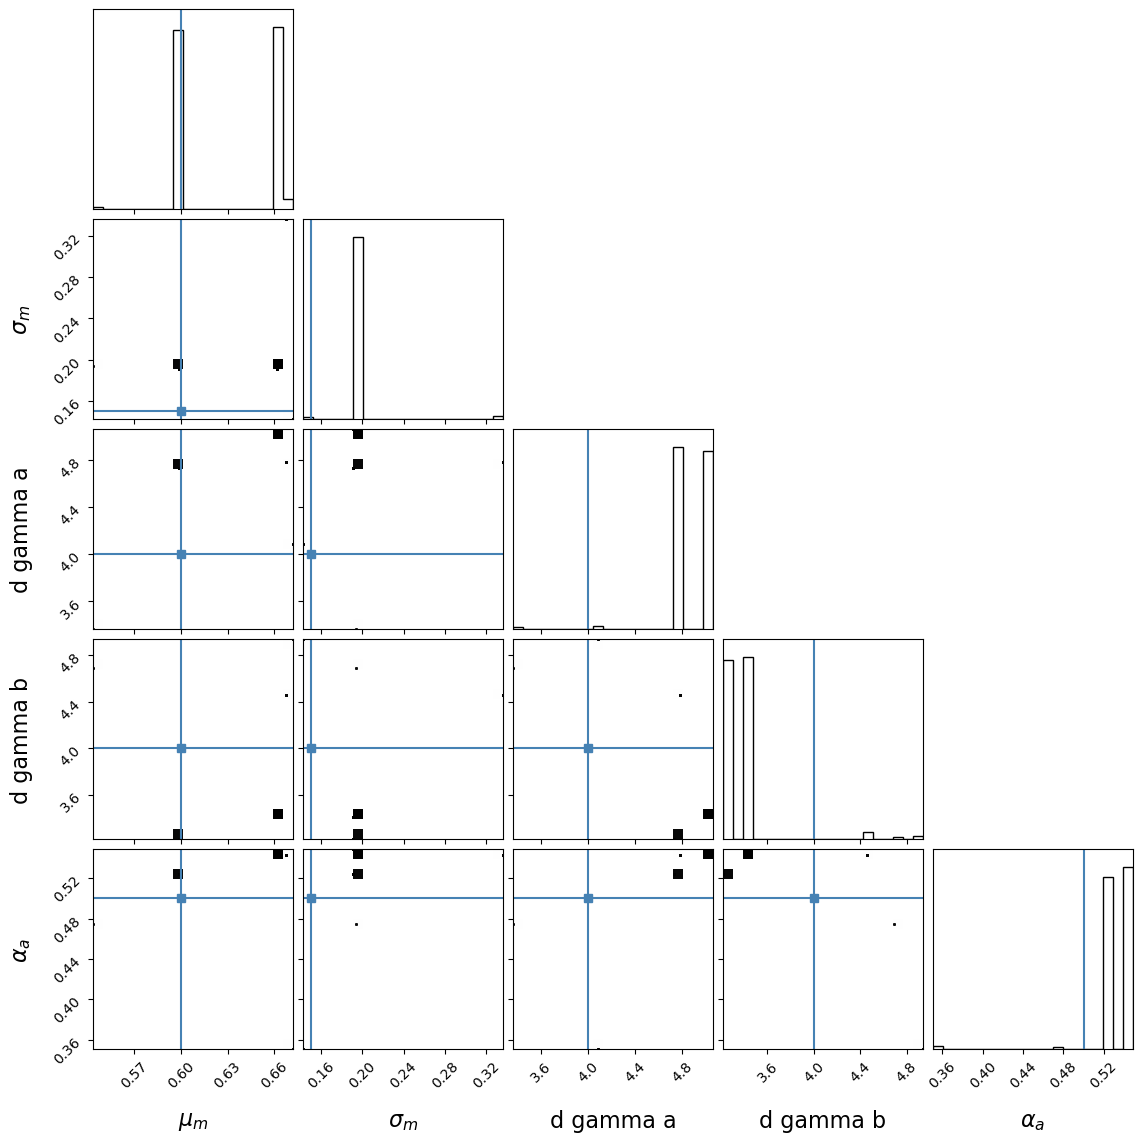

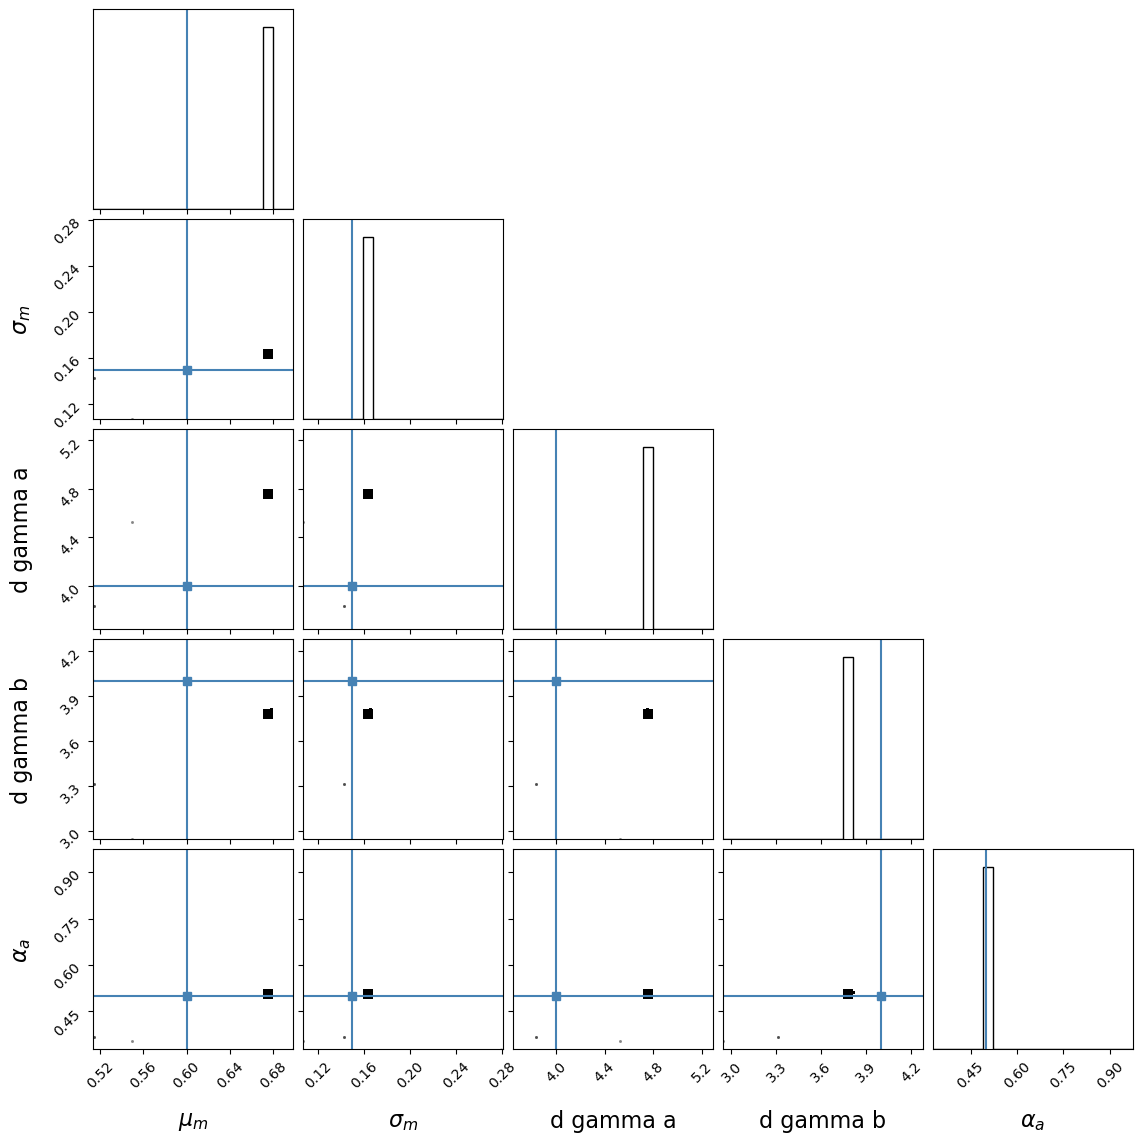

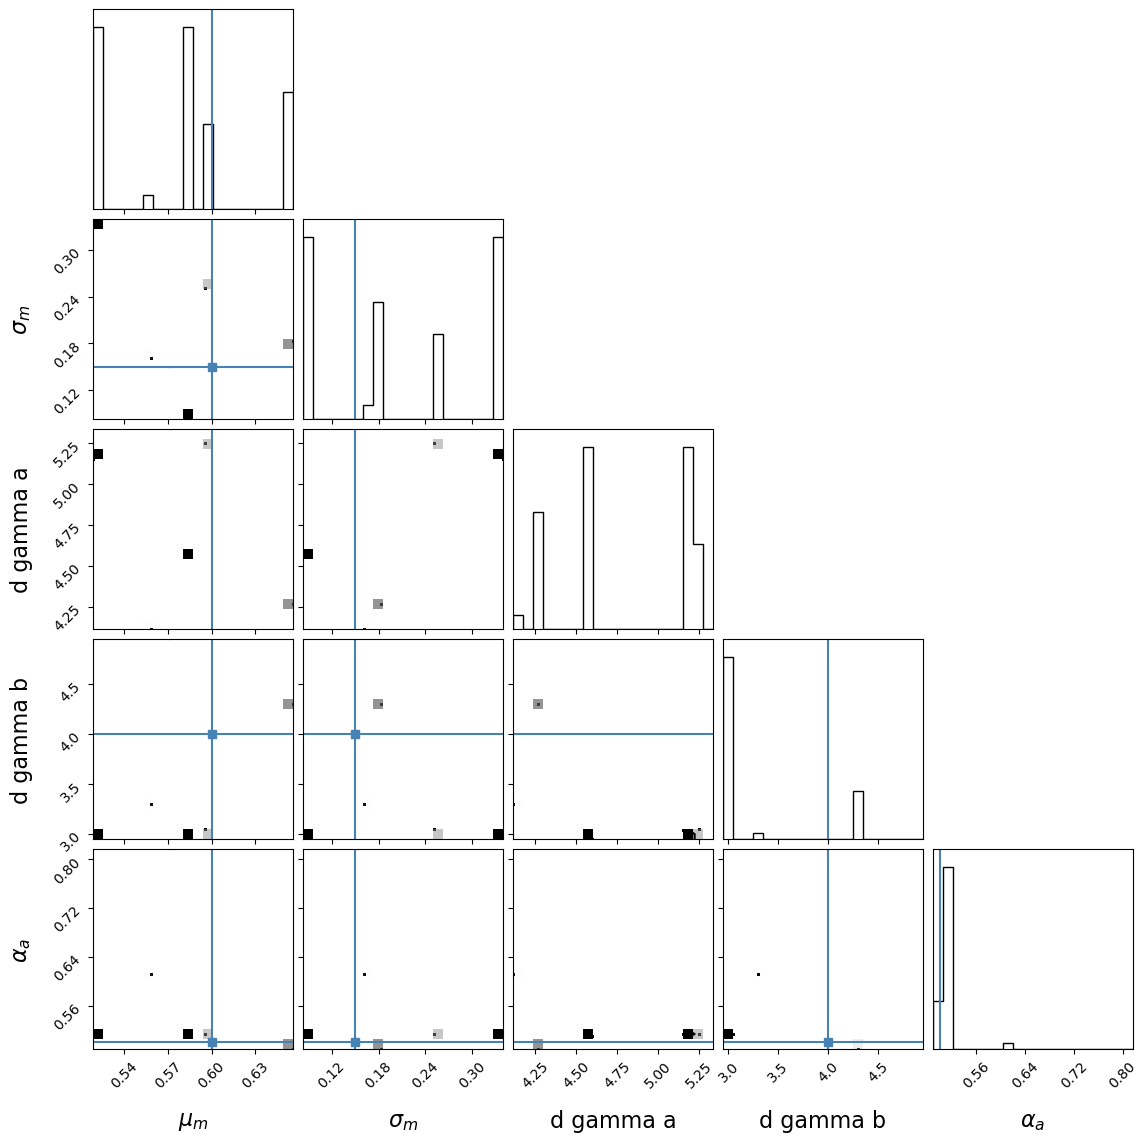

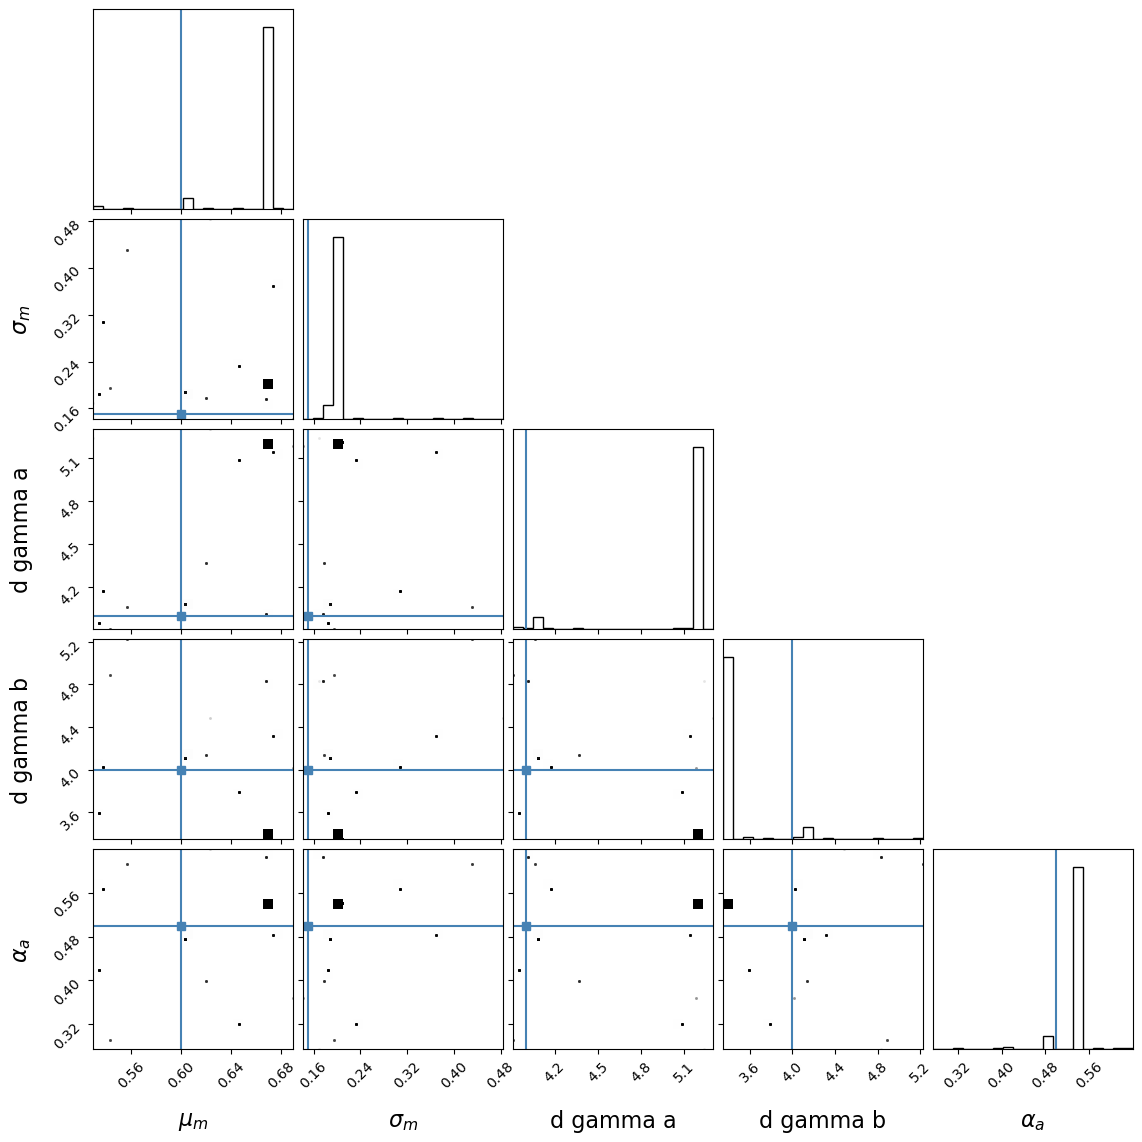

In [66]:
for i in range(10):
    plt.rcParams.update({'axes.labelsize':16})
    # samples = ensemble.get_chain()['model_0'].reshape(-1, ndim)
    samples = ensemble.get_chain()['model_0'].reshape(ensemble.get_chain()['model_0'].shape[0],10,5)[:,i,:]
    corner(samples, truths=truths,labels=[r'$\mu_m$',r'$\sigma_m$',r'd gamma a',r'd gamma b',r'$\alpha_a$'])
    # plt.savefig('first_initial_result.png',dpi=200)
    plt.show()